In [20]:
options(Seurat.object.assay.version = 'v3') 

library(Seurat)
library(ggridges)
library(ggplot2)
library(Mixscale)
library(Seurat)
library(ggplot2)
library(patchwork)
library(scales)
library(dplyr)
library(reshape2)
library(cowplot)
library(harmony)
library(pROC)

In [21]:
#Reload complete seurat object
merged_counts_filtered_combined <- readRDS("/data/tracy_data/perturbseq_qc.rds")

In [22]:
# Reload TCDD and pbs seurat object
merged_counts_perturb1_tcdd_pbs <- readRDS("/data/tracy_data/perturbseq_qc_tcddafterharmony.rds")

In [23]:
# Reload Calcification and DMEM seurat object
merged_counts_perturb1_cal_dmem <- readRDS("/data/tracy_data/perturbseq_qc_calcificationafterharmony.rds")

In [24]:
UpdateSeuratObject(merged_counts_filtered_combined) 

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in feature

Validating object structure for Assay ‘RNA’

Validating object structure for Assay ‘feature’

Object representation is consistent with the most current Seurat version



An object of class Seurat 
36646 features across 16582 samples within 2 assays 
Active assay: RNA (36602 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: feature

In [25]:
UpdateSeuratObject(merged_counts_perturb1_tcdd_pbs) 

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Updating matrix keys for DimReduc ‘pca’

Updating matrix keys for DimReduc ‘umap’

Updating matrix keys for DimReduc ‘harmony’

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in feature

Updating slots in RNA_nn

Setting default assay of RNA_nn to RNA

Updating slots in RNA_snn

Setting default assay of RNA_snn to RNA

Updating slots in pca

Updating slots in umap

Setting umap DimReduc to global

Updating slots in harmony

Setting assay used for NormalizeData.RNA to RNA

Setting assay used for FindVariableFeatures.RNA to RNA

Setting assay used for ScaleData.RNA to RNA

Setting assay used for RunPCA.RNA to RNA

Setting assay used for RunUMAP.RNA.pca to RNA

Setting assay used for FindNeighbors.RNA.pca to RNA

Setting assay used for NormalizeData.feature to feature

Setting assay used for Seurat..Project

An object of class Seurat 
36646 features across 6308 samples within 2 assays 
Active assay: RNA (36602 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: feature
 3 dimensional reductions calculated: pca, umap, harmony

In [26]:
UpdateSeuratObject(merged_counts_perturb1_cal_dmem) 

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Updating matrix keys for DimReduc ‘pca’

Updating matrix keys for DimReduc ‘umap’

Updating matrix keys for DimReduc ‘harmony’

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in feature

Updating slots in RNA_nn

Setting default assay of RNA_nn to RNA

Updating slots in RNA_snn

Setting default assay of RNA_snn to RNA

Updating slots in pca

Updating slots in umap

Setting umap DimReduc to global

Updating slots in harmony

Setting assay used for NormalizeData.RNA to RNA

Setting assay used for FindVariableFeatures.RNA to RNA

Setting assay used for ScaleData.RNA to RNA

Setting assay used for RunPCA.RNA to RNA

Setting assay used for RunUMAP.RNA.pca to RNA

Setting assay used for FindNeighbors.RNA.pca to RNA

Setting assay used for NormalizeData.feature to feature

Setting assay used for Seurat..Project

An object of class Seurat 
36646 features across 1920 samples within 2 assays 
Active assay: RNA (36602 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: feature
 3 dimensional reductions calculated: pca, umap, harmony

In [ ]:
########################################################################################################################

In [ ]:
###load complete seurat object, followed by normalization and add guides info

In [27]:
merged_counts_filtered_combined <- subset(merged_counts_filtered_combined, subset = nFeature_RNA > 1500 & 
                             nFeature_RNA < 10000 &  nCount_RNA > 2500 & percent.mt < 7.5)

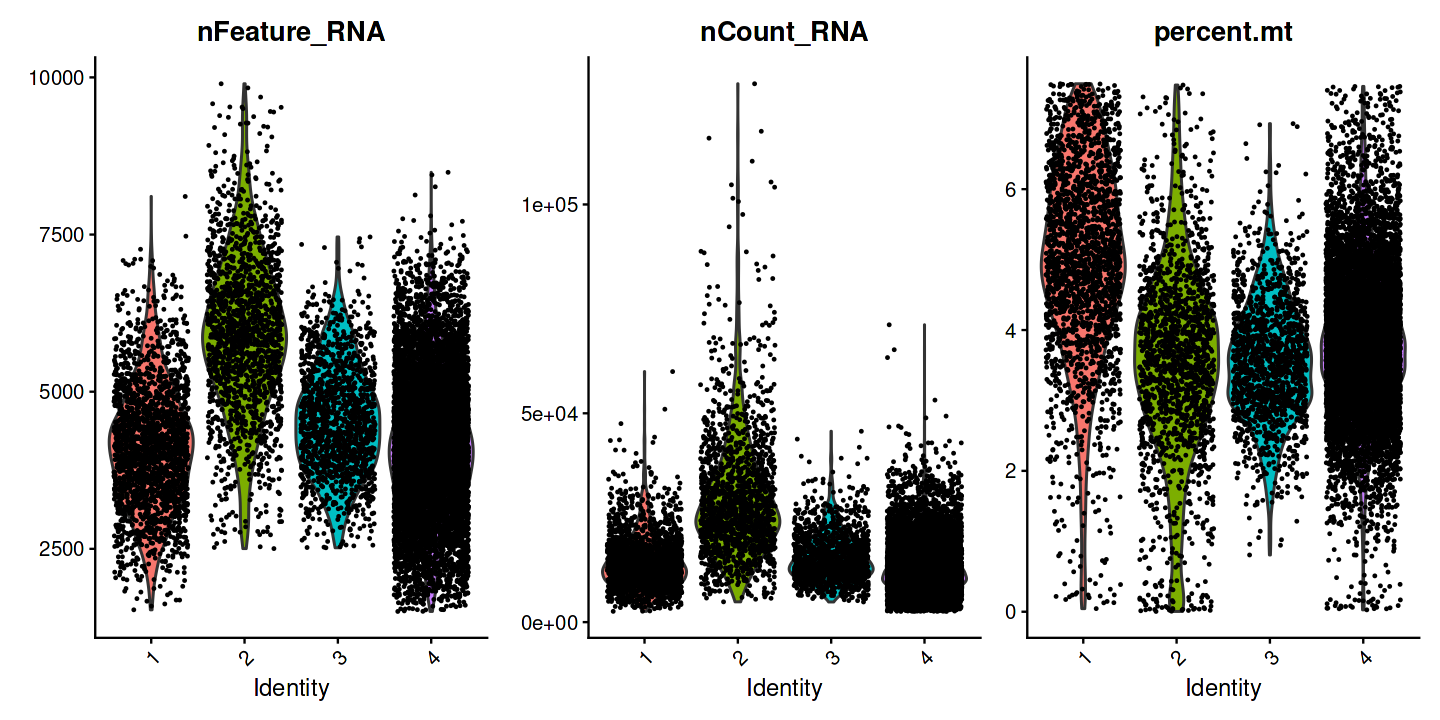

In [28]:
options(repr.plot.height = 6, repr.plot.width = 12)
VlnPlot(merged_counts_filtered_combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0.1)

In [29]:
table(merged_counts_filtered_combined$group1)


  cal  dmem   pbs  tcdd 
 2106  1625  1439 10427 

Centering and scaling data matrix



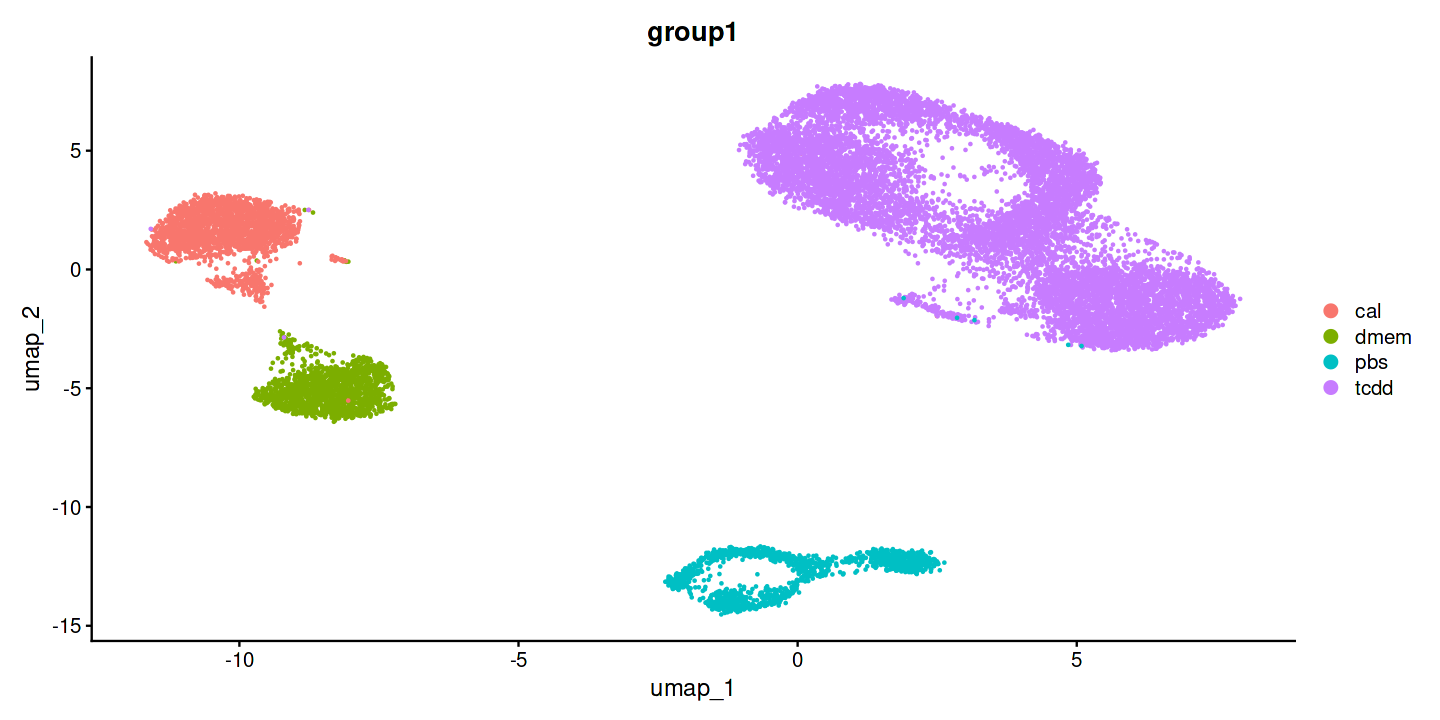

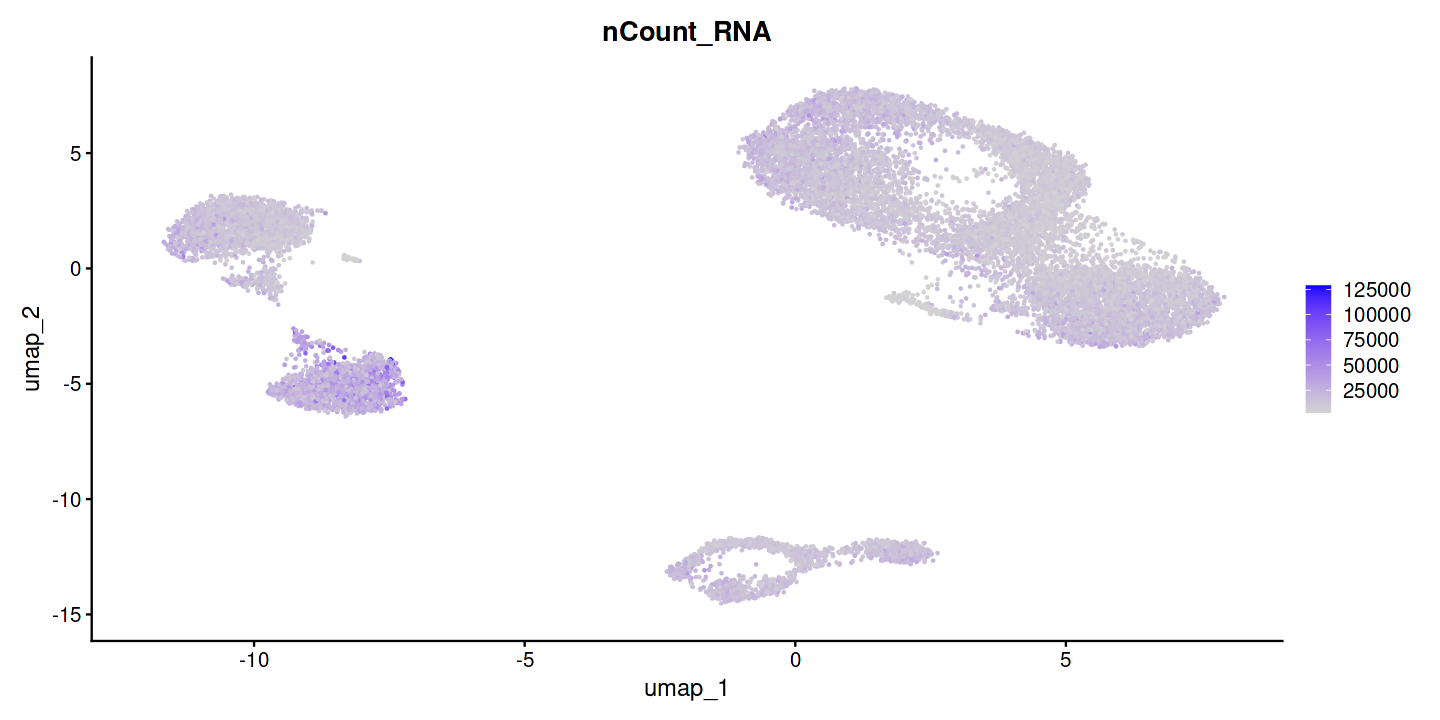

In [30]:
# Normalization
merged_counts_filtered_combined_no <- NormalizeData(merged_counts_filtered_combined, normalization.method = "LogNormalize", scale.factor = 10000)
# Feature selection
merged_counts_filtered_combined_no <- FindVariableFeatures(merged_counts_filtered_combined_no, selection.method = "vst", nfeatures = 2000)
# Scaling the data
all.genes <- rownames(merged_counts_filtered_combined_no)
merged_counts_filtered_combined_no <- ScaleData(merged_counts_filtered_combined_no, features = all.genes)
#These are now standard steps in the Seurat workflow for visualization and clustering
merged_counts_filtered_combined_no <- RunPCA(merged_counts_filtered_combined_no, verbose = FALSE)
merged_counts_filtered_combined_no <- RunUMAP(merged_counts_filtered_combined_no, dims = 1:50, verbose = FALSE)
merged_counts_filtered_combined_no <- FindNeighbors(merged_counts_filtered_combined_no, dims = 1:50, verbose = FALSE)
##resolution
merged_counts_filtered_combined_no <- FindClusters(merged_counts_filtered_combined_no, resolution = 0.5, verbose = FALSE)
DimPlot(merged_counts_filtered_combined_no, group.by = "group1")
FeaturePlot(merged_counts_filtered_combined_no, features = "nCount_RNA", min.cutoff = 1000)

In [31]:
######add guides information##########

In [32]:
perturb_counts <- read.csv('/VOSNE/tracy/ahr_perturbseq/outs/count/crispr_analysis/protospacer_calls_per_cell.csv', header = TRUE)

In [33]:
##filter NA cells without guides information
row_ids <- perturb_counts$cell_barcode
merged_counts_filtered <- merged_counts_filtered_combined_no[,(colnames(merged_counts_filtered_combined_no) %in% row_ids)]
merged_counts_filtered[[]]
##Add guides information
merged_counts_perturb <- NormalizeData(
  object = merged_counts_filtered, 
  assay = "feature", 
  normalization.method = "CLR", 
  margin = 2)
merged_counts_perturb@meta.data$cell_barcode <- row.names(merged_counts_perturb@meta.data)
merged_counts_perturb@meta.data <- merged_counts_perturb@meta.data %>% left_join(y=perturb_counts, by = c('cell_barcode'))
merged_counts_perturb@meta.data$cell_barcode <- row.names(merged_counts_perturb@meta.data)
merged_counts_perturb@meta.data
#Add rowname vector back to object metadata
row_names <- rownames(x = merged_counts_filtered@meta.data)
rownames(merged_counts_perturb@meta.data) <- row_names
merged_counts_perturb[[]]
table(merged_counts_perturb$num_features)

orig.ident nCount_RNA nFeature_RNA nCount_feature
AAACCCATCAAGTCGT-2 2          22711      5535           226         
AAACGAACAACCTAAC-2 2          36180      7133          6848         
AAACGAACATGGTACT-2 2          40016      7184          1875         
AAACGAAGTTCCGGTG-2 2          35103      6319           683         
AAACGAATCCTCACTG-2 2          21186      5473          3207         
AAACGCTAGTTCGGTT-2 2          18875      5044           609         
AAAGAACAGCCTCATA-2 2          31136      6671           449         
AAAGAACCACCCTTAC-2 2          36281      6984           614         
AAAGAACCATCGCCTT-2 2          36498      6146            59         
AAAGAACGTTGGAGAC-2 2          20884      5204           638         
AAAGGTACATCATTGG-2 2          22686      5457           330         
AAAGGTAGTGCACATT-2 2          24360      5551           695         
AAAGTCCTCGCGTCGA-2 2          13401      4343          1527         
AAAGTGAAGCCATTGT-2 2          22762      5805           985         
AAAGTGAAGGGACCAT-2 2          22317      5110          1502         
AAATGGAAGGACTATA-2 2          13964      4268           550         
AACAACCAGTTACGAA-2 2          27807      6258           112         
AACAACCTCGCCAATA-2 2          28860      6218          1227         
AACAAGATCTAGTACG-2 2          15869      4364           363         
AACACACCACTCCGAG-2 2          26928      5814          1037         
AACACACGTTCGGCGT-2 2          35242      7205          1029         
AACAGGGCAGCTGGTC-2 2          33086      6534           756         
AACCAACCAAGCACCC-2 2          28076      6309         13986         
AACCAACGTTAAACCC-2 2          88656      9222          6295         
AACCACAAGTCCGTCG-2 2          27929      5789          1429         
AACCACAGTTTCCCAC-2 2          35636      6982           649         
AACCATGCACAAAGTA-2 2          35154      6579          1219         
AACCATGGTAACATCC-2 2          50323      7835           538         
AACCCAAAGCCTAGGA-2 2          36545      6814           437         
AACCCAATCAATGTCG-2 2          34609      6389          2790         
⋮                  ⋮          ⋮          ⋮            ⋮             
TTGCATTTCGCGGACT-3 3          24332      5884          160          
TTGCCTGCAAAGCTAA-3 3          15992      4325          599          
TTGCGTCTCAACACCA-3 3          22627      5823         1879          
TTGCGTCTCACCATGA-3 3          21286      5554          194          
TTGCTGCAGGTTGGTG-3 3          18344      4339          140          
TTGGATGCAGCACAGA-3 3          12564      4174         1286          
TTGGATGGTATCCCTC-3 3          16410      4397           22          
TTGGGCGGTGGTTTGT-3 3          21177      5838         1059          
TTGGGCGTCGGAATTC-3 3          10677      3575          803          
TTGGTTTTCCATTCGC-3 3           9553      3935          666          
TTGTGGAAGTCGAAGC-3 3          14321      4319          805          
TTGTTCAGTGGCTCTG-3 3           8130      3425          244          
TTGTTGTGTGATGTAA-3 3           8819      3024          603          
TTGTTTGAGATTTGCC-3 3           8181      3343          345          
TTGTTTGAGCGTGCTC-3 3           8304      3189          600          
TTGTTTGTCTAGTGAC-3 3          10162      3765          648          
TTTACTGAGTCAATCC-3 3          14453      4646          956          
TTTACTGCAGTCGGTC-3 3           9004      3435           78          
TTTAGTCCATGTGCCG-3 3          10284      3718          237          
TTTAGTCGTGTCCATA-3 3           5943      2638          580          
TTTAGTCTCGCCTAGG-3 3          19744      5698          259          
TTTATGCAGTCAGGGT-3 3          11857      4263          174          
TTTATGCAGTGCCAGA-3 3          12639      3960          400          
TTTATGCCAACCTATG-3 3           8621      3359          698          
TTTCACAAGACTGTTC-3 3          11762      3642          601          
TTTCCTCTCGGATACT-3 3          11515      4024          682          
TTTGACTAGTATTCCG-

Normalizing across cells



orig.ident nCount_RNA nFeature_RNA nCount_feature nFeature_feature group
1     2          22711      5535           226           8               2    
2     2          36180      7133          6848           9               2    
3     2          40016      7184          1875          18               2    
4     2          35103      6319           683          19               2    
5     2          21186      5473          3207          11               2    
6     2          18875      5044           609           2               2    
7     2          31136      6671           449           5               2    
8     2          36281      6984           614           5               2    
9     2          36498      6146            59           6               2    
10    2          20884      5204           638           8               2    
11    2          22686      5457           330           3               2    
12    2          24360      5551           695          12               2    
13    2          13401      4343          1527           6               2    
14    2          22762      5805           985           6               2    
15    2          22317      5110          1502          16               2    
16    2          13964      4268           550           4               2    
17    2          27807      6258           112          17               2    
18    2          28860      6218          1227           8               2    
19    2          15869      4364           363           3               2    
20    2          26928      5814          1037          19               2    
21    2          35242      7205          1029           4               2    
22    2          33086      6534           756           8               2    
23    2          28076      6309         13986          20               2    
24    2          88656      9222          6295          21               2    
25    2          27929      5789          1429          10               2    
26    2          35636      6982           649           5               2    
27    2          35154      6579          1219           7               2    
28    2          50323      7835           538          24               2    
29    2          36545      6814           437          17               2    
30    2          34609      6389          2790           3               2    
⋮     ⋮          ⋮          ⋮            ⋮              ⋮                ⋮    
12263 3          24332      5884          160            2               3    
12264 3          15992      4325          599            4               3    
12265 3          22627      5823         1879            9               3    
12266 3          21286      5554          194           12               3    
12267 3          18344      4339          140            5               3    
12268 3          12564      4174         1286            9               3    
12269 3          16410      4397           22            8               3    
12270 3          21177      5838         1059            7               3    
12271 3          10677      3575          803            9               3    
12272 3           9553      3935          666            5               3    
12273 3          14321      4319          805            8               3    
12274 3           8130      3425          244            3               3    
12275 3           8819      3024          603            4               3    
12276 3           8181      3343          345            4               3    
12277 3           8304      3189          600            4               3    
12278 3          10162      3765          648            4               3    
12279 3          14453      4646          956            2               3    
12280 3           9004      3435           78            3               3    
12281 3          10284      3718          237           

orig.ident nCount_RNA nFeature_RNA nCount_feature
AAACCCATCAAGTCGT-2 2          22711      5535           226         
AAACGAACAACCTAAC-2 2          36180      7133          6848         
AAACGAACATGGTACT-2 2          40016      7184          1875         
AAACGAAGTTCCGGTG-2 2          35103      6319           683         
AAACGAATCCTCACTG-2 2          21186      5473          3207         
AAACGCTAGTTCGGTT-2 2          18875      5044           609         
AAAGAACAGCCTCATA-2 2          31136      6671           449         
AAAGAACCACCCTTAC-2 2          36281      6984           614         
AAAGAACCATCGCCTT-2 2          36498      6146            59         
AAAGAACGTTGGAGAC-2 2          20884      5204           638         
AAAGGTACATCATTGG-2 2          22686      5457           330         
AAAGGTAGTGCACATT-2 2          24360      5551           695         
AAAGTCCTCGCGTCGA-2 2          13401      4343          1527         
AAAGTGAAGCCATTGT-2 2          22762      5805           985         
AAAGTGAAGGGACCAT-2 2          22317      5110          1502         
AAATGGAAGGACTATA-2 2          13964      4268           550         
AACAACCAGTTACGAA-2 2          27807      6258           112         
AACAACCTCGCCAATA-2 2          28860      6218          1227         
AACAAGATCTAGTACG-2 2          15869      4364           363         
AACACACCACTCCGAG-2 2          26928      5814          1037         
AACACACGTTCGGCGT-2 2          35242      7205          1029         
AACAGGGCAGCTGGTC-2 2          33086      6534           756         
AACCAACCAAGCACCC-2 2          28076      6309         13986         
AACCAACGTTAAACCC-2 2          88656      9222          6295         
AACCACAAGTCCGTCG-2 2          27929      5789          1429         
AACCACAGTTTCCCAC-2 2          35636      6982           649         
AACCATGCACAAAGTA-2 2          35154      6579          1219         
AACCATGGTAACATCC-2 2          50323      7835           538         
AACCCAAAGCCTAGGA-2 2          36545      6814           437         
AACCCAATCAATGTCG-2 2          34609      6389          2790         
⋮                  ⋮          ⋮          ⋮            ⋮             
TTGCATTTCGCGGACT-3 3          24332      5884          160          
TTGCCTGCAAAGCTAA-3 3          15992      4325          599          
TTGCGTCTCAACACCA-3 3          22627      5823         1879          
TTGCGTCTCACCATGA-3 3          21286      5554          194          
TTGCTGCAGGTTGGTG-3 3          18344      4339          140          
TTGGATGCAGCACAGA-3 3          12564      4174         1286          
TTGGATGGTATCCCTC-3 3          16410      4397           22          
TTGGGCGGTGGTTTGT-3 3          21177      5838         1059          
TTGGGCGTCGGAATTC-3 3          10677      3575          803          
TTGGTTTTCCATTCGC-3 3           9553      3935          666          
TTGTGGAAGTCGAAGC-3 3          14321      4319          805          
TTGTTCAGTGGCTCTG-3 3           8130      3425          244          
TTGTTGTGTGATGTAA-3 3           8819      3024          603          
TTGTTTGAGATTTGCC-3 3           8181      3343          345          
TTGTTTGAGCGTGCTC-3 3           8304      3189          600          
TTGTTTGTCTAGTGAC-3 3          10162      3765          648          
TTTACTGAGTCAATCC-3 3          14453      4646          956          
TTTACTGCAGTCGGTC-3 3           9004      3435           78          
TTTAGTCCATGTGCCG-3 3          10284      3718          237          
TTTAGTCGTGTCCATA-3 3           5943      2638          580          
TTTAGTCTCGCCTAGG-3 3          19744      5698          259          
TTTATGCAGTCAGGGT-3 3          11857      4263          174          
TTTATGCAGTGCCAGA-3 3          12639      3960          400          
TTTATGCCAACCTATG-3 3           8621      3359          698          
TTTCACAAGACTGTTC-3 3          11762      3642          601          
TTTCCTCTCGGATACT-3 3          11515      4024          682          
TTTGACTAGTATTCCG-


   1    2    3    4    5    6    7    8    9   10   11 
1084 9278  449 1164   96  160   20   29    6    3    3 

orig.ident nCount_RNA nFeature_RNA nCount_feature
AAACGAAGTTCCGGTG-2 2          35103      6319          683          
AAACGAATCCTCACTG-2 2          21186      5473         3207          
AAAGAACAGCCTCATA-2 2          31136      6671          449          
AAAGAACCACCCTTAC-2 2          36281      6984          614          
AAAGAACCATCGCCTT-2 2          36498      6146           59          
AAAGAACGTTGGAGAC-2 2          20884      5204          638          
AAAGGTACATCATTGG-2 2          22686      5457          330          
AAAGGTAGTGCACATT-2 2          24360      5551          695          
AAAGTGAAGCCATTGT-2 2          22762      5805          985          
AAAGTGAAGGGACCAT-2 2          22317      5110         1502          
AAATGGAAGGACTATA-2 2          13964      4268          550          
AACAACCAGTTACGAA-2 2          27807      6258          112          
AACAACCTCGCCAATA-2 2          28860      6218         1227          
AACAAGATCTAGTACG-2 2          15869      4364          363          
AACACACCACTCCGAG-2 2          26928      5814         1037          
AACACACGTTCGGCGT-2 2          35242      7205         1029          
AACAGGGCAGCTGGTC-2 2          33086      6534          756          
AACCACAAGTCCGTCG-2 2          27929      5789         1429          
AACCATGCACAAAGTA-2 2          35154      6579         1219          
AACCATGGTAACATCC-2 2          50323      7835          538          
AACCCAAAGCCTAGGA-2 2          36545      6814          437          
AACCTGATCCATTTCA-2 2          30819      6447          350          
AACGAAACATGAATCC-2 2          22074      5551         2368          
AACGAAAGTAAGATCA-2 2          18922      4508         5831          
AACGAAATCAAGCTTG-2 2          30703      6499         1389          
AACGAAATCCTTTGAT-2 2          32484      6180          328          
AACGGGACAGGGACTA-2 2          31307      6292          855          
AACGTCAAGGGCAGTT-2 2          68104      7791         1611          
AACTTCTAGCGTGTCC-2 2          19445      4792          192          
AACTTCTCATCTAGAC-2 2          27592      6094          394          
⋮                  ⋮          ⋮          ⋮            ⋮             
TTCTAACTCGTTCAGA-3 3           6232      2743          432          
TTCTAGTAGCACCGAA-3 3          18493      5514          829          
TTCTAGTCAGCAAGAC-3 3          21586      6002          169          
TTCTGTACATCATTTC-3 3           9332      3659          841          
TTCTTCCCACCTGCGA-3 3          13278      4655          285          
TTCTTCCTCAAGCCCG-3 3          14202      4861           84          
TTCTTGAAGCCATATC-3 3           6301      3013          230          
TTCTTGAAGCGACTTT-3 3           9899      4182           74          
TTGAACGGTGACATCT-3 3           9964      3468         1026          
TTGAGTGAGTAGACCG-3 3          11640      4354          139          
TTGCATTGTAGATTGA-3 3          10784      3688          362          
TTGCATTTCGCGGACT-3 3          24332      5884          160          
TTGCCTGCAAAGCTAA-3 3          15992      4325          599          
TTGGATGGTATCCCTC-3 3          16410      4397           22          
TTGGGCGGTGGTTTGT-3 3          21177      5838         1059          
TTGGGCGTCGGAATTC-3 3          10677      3575          803          
TTGGTTTTCCATTCGC-3 3           9553      3935          666          
TTGTTCAGTGGCTCTG-3 3           8130      3425          244          
TTGTTGTGTGATGTAA-3 3           8819      3024          603          
TTGTTTGAGATTTGCC-3 3           8181      3343          345          
TTGTTTGAGCGTGCTC-3 3           8304      3189          600          
TTGTTTGTCTAGTGAC-3 3          10162      3765          648          
TTTACTGAGTCAATCC-3 3          14453      4646          956          
TTTAGTCCATGTGCCG-3 3          10284      3718          237          
TTTATGCCAACCTATG-3 3           8621      3359          698          
TTTCACAAGACTGTTC-3 3          11762      3642          601          
TTTGACTAGTATTCCG-

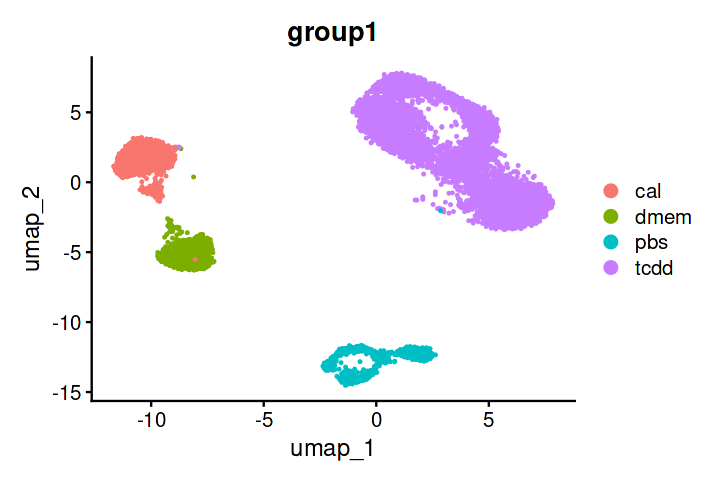

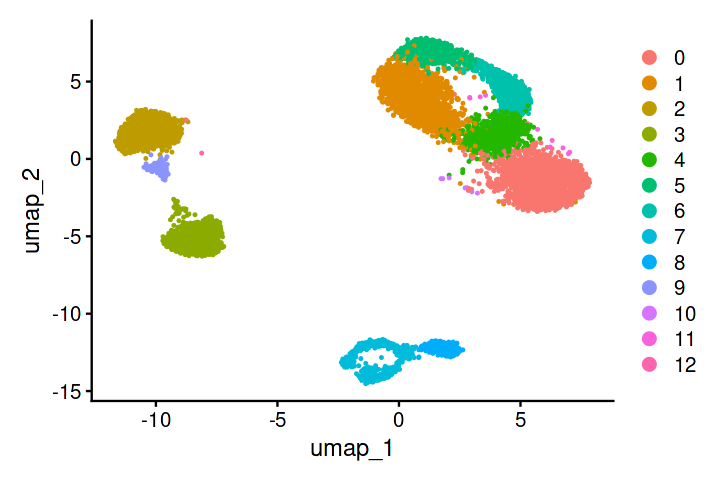

In [34]:
##another method to specify guides##
##subset only 1 guide##
selected_identname <- "num_features"
selected_ident <- c(1)
selected_rownumbers <- which(merged_counts_perturb[[]][,selected_identname] %in% selected_ident)
selected_cells <- rownames(merged_counts_perturb[[]][selected_rownumbers,])
merged_counts_perturb_1guide_object <- subset(merged_counts_perturb, cells = selected_cells) # subset from previously selected cells
##subset only 2 guides##
selected_identname <- "num_features"
selected_ident <- c(2)
selected_rownumbers <- which(merged_counts_perturb[[]][,selected_identname] %in% selected_ident)
selected_cells <- rownames(merged_counts_perturb[[]][selected_rownumbers,])
merged_counts_perturb_2guide_object <- subset(merged_counts_perturb, cells = selected_cells) # subset from previously selected cells
#Idents(merged_counts_perturb_2guide_object) <- "feature_call"
#twoguides <- table(merged_counts_perturb_2guide_object$feature_call)
#write.csv(twoguides, "/home/tracy/twoguides.csv")
#chatgpt
merged_counts_perturb_2guide_object@meta.data$guide3 <- grepl("TWIST1.*\\|TWIST1.*|NEG_CTRL.*\\|NEG_CTRL.*|TCF2.*\\|TCF2.* |ARNT.*\\|ARNT.*|ARNT.*\\|NEG_CTRL.*|HSP90AA1.*\\|HSP90AA1.*|HSP90AA1.*\\|NEG_CTRL.*|KLF4.*\\|KLF4.*|KLF4.*\\|NEG_CTRL.*|NFE2L2.*\\|NFE2L2.*|NFE2L2.*\\|NEG_CTRL.*|SMAD3.*\\|SMAD3.*|SMAD3.*\\|NEG_CTRL.*|SMARCA4.*\\|SMARCA4.*|SMARCA4.*\\|NEG_CTRL.*|SOX9.*\\|SOX9.*|SOX9.*\\|NEG_CTRL.*|TIPARP.*\\|TIPARP.*|TIPARP.*\\|NEG_CTRL.*|TWIST1.*\\|NEG_CTRL.*|TCF2.*\\|NEG_CTRL.*|TCF21.*\\|TCF21.*", merged_counts_perturb_2guide_object$feature_call)
##subset cells with guide3 is TRUE##
selected_identname <- c("guide3")
selected_ident <- c("TRUE")
selected_rownumbers <- which(merged_counts_perturb_2guide_object[[]][,selected_identname] %in% selected_ident)
selected_cells <- rownames(merged_counts_perturb_2guide_object[[]][selected_rownumbers,])
merged_counts_perturb_2guide_object <- subset(merged_counts_perturb_2guide_object, cells = selected_cells) # subset from previously selected cells
merged_counts_perturb_2guide_object@meta.data$guide <- gsub("\\-.*","", merged_counts_perturb_2guide_object$feature_call)
##extract row names of two subset and combine
rn1 <- rownames(merged_counts_perturb_1guide_object@meta.data)
rn2 <- rownames(merged_counts_perturb_2guide_object@meta.data)
all_rn <- c(rn1, rn2)
write.csv(all_rn, "/home/gzq0002/all_rn")
##only kept all_rn cells with clean guides information
row_ids <- all_rn
merged_counts_perturb1 <- merged_counts_perturb[,(colnames(merged_counts_perturb) %in% row_ids)]
merged_counts_perturb1[[]]
##specify the guide information##
merged_counts_perturb1@meta.data$guide <- gsub("\\-.*","", merged_counts_perturb1$feature_call)
options(repr.plot.height = 4, repr.plot.width = 6)
DimPlot(merged_counts_perturb1, group.by = "group1", raster=FALSE)
DimPlot(merged_counts_perturb1, raster=FALSE)

In [35]:
table(merged_counts_perturb1$guide)


    ARNT HSP90AA1     KLF4 NEG_CTRL   NFE2L2    SMAD3  SMARCA4     SOX9 
     377      736     1039      635      588      527      937      656 
   TCF21   TIPARP   TWIST1 
     768      930     1035 

In [36]:
#####harmony#####

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations



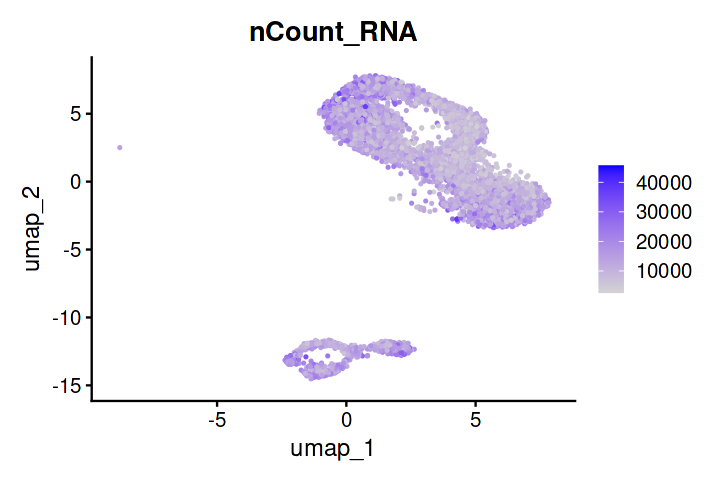

orig.ident nCount_RNA nFeature_RNA nCount_feature
AAACCCAAGTCACTGT-4 4          13948      4221          691          
AAACCCAAGTTGCTGT-4 4          10308      3900          128          
AAACCCACATCGCTGG-4 4           9955      3882          101          
AAACCCAGTGCCTAAT-4 4          13446      4572          164          
AAACCCATCATCGGGC-4 4          19663      5336          911          
AAACGAAAGCTTGTGT-4 4           7693      3175          532          
AAACGAACAAACTCGT-4 4          15810      5054          471          
AAACGAACACTGTGTA-4 4          14097      4161           54          
AAACGAACAGAACATA-4 4           9462      3421           77          
AAACGAAGTAGCGCCT-4 4          14906      4935         1578          
AAACGAAGTATATGGA-4 4          12293      4200          325          
AAACGAATCTTTGCGC-4 4           7053      2913          191          
AAACGCTAGACATCAA-4 4           6667      3038          741          
AAACGCTAGACGAAGA-4 4          12395      4241          220          
AAACGCTCAACTCGAT-4 4          10762      4030         1058          
AAACGCTGTAGCCAGA-4 4          19626      5208          273          
AAACGCTTCTCTATGT-4 4           7629      3459          601          
AAACGCTTCTGCCCTA-4 4           8699      3516          391          
AAAGAACAGGCTAAAT-4 4          12850      4000          710          
AAAGAACAGGGATCTG-4 4           6759      2611          255          
AAAGAACCAAATCCCA-4 4           8968      3716         1051          
AAAGAACCAGACGCTC-4 4          12344      4459          307          
AAAGAACTCACCTCGT-4 4          14369      4840          752          
AAAGAACTCCAATCTT-4 4           8244      3361          451          
AAAGAACTCCCTATTA-4 4           5280      2607          348          
AAAGAACTCCTCTTTC-4 4           8233      3138           45          
AAAGAACTCGCATTAG-4 4           8525      3299          145          
AAAGGATCACTTGGGC-4 4           7724      2899          773          
AAAGGATCATTGACCA-4 4           9727      3610          742          
AAAGGATGTAAGTAGT-4 4           6775      2836          677          
⋮                  ⋮          ⋮          ⋮            ⋮             
TTCTAACTCGTTCAGA-3 3           6232      2743          432          
TTCTAGTAGCACCGAA-3 3          18493      5514          829          
TTCTAGTCAGCAAGAC-3 3          21586      6002          169          
TTCTGTACATCATTTC-3 3           9332      3659          841          
TTCTTCCCACCTGCGA-3 3          13278      4655          285          
TTCTTCCTCAAGCCCG-3 3          14202      4861           84          
TTCTTGAAGCCATATC-3 3           6301      3013          230          
TTCTTGAAGCGACTTT-3 3           9899      4182           74          
TTGAACGGTGACATCT-3 3           9964      3468         1026          
TTGAGTGAGTAGACCG-3 3          11640      4354          139          
TTGCATTGTAGATTGA-3 3          10784      3688          362          
TTGCATTTCGCGGACT-3 3          24332      5884          160          
TTGCCTGCAAAGCTAA-3 3          15992      4325          599          
TTGGATGGTATCCCTC-3 3          16410      4397           22          
TTGGGCGGTGGTTTGT-3 3          21177      5838         1059          
TTGGGCGTCGGAATTC-3 3          10677      3575          803          
TTGGTTTTCCATTCGC-3 3           9553      3935          666          
TTGTTCAGTGGCTCTG-3 3           8130      3425          244          
TTGTTGTGTGATGTAA-3 3           8819      3024          603          
TTGTTTGAGATTTGCC-3 3           8181      3343          345          
TTGTTTGAGCGTGCTC-3 3           8304      3189          600          
TTGTTTGTCTAGTGAC-3 3          10162      3765          648          
TTTACTGAGTCAATCC-3 3          14453      4646          956          
TTTAGTCCATGTGCCG-3 3          10284      3718          237          
TTTATGCCAACCTATG-3 3           8621      3359          698          
TTTCACAAGACTGTTC-3 3          11762      3642          601          
TTTGACTAGTATTCCG-

harmony_1 harmony_2  harmony_3 harmony_4 harmony_5
AAACCCAAGTCACTGT-4  1.835073  8.2824541 -2.981794 1.6645988 6.014034 
AAACCCAAGTTGCTGT-4 11.008749 -9.1345627  2.428683 0.8852863 3.726239 
AAACCCACATCGCTGG-4  6.131809  1.9414229 -4.750170 1.4737174 4.689419 
AAACCCAGTGCCTAAT-4  9.054021  0.1225056 -1.791533 1.5055152 6.252003 
AAACCCATCATCGGGC-4  5.876401  0.1786750  3.209779 5.0532425 4.175724

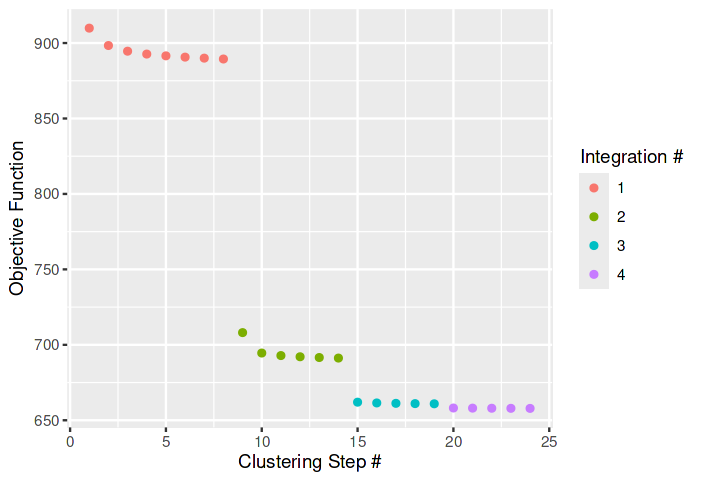

09:54:20 UMAP embedding parameters a = 0.9922 b = 1.112

09:54:20 Read 6308 rows and found 20 numeric columns

09:54:20 Using Annoy for neighbor search, n_neighbors = 30

09:54:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:54:20 Writing NN index file to temp file /tmp/RtmpTKAZbj/file8518477ed2827

09:54:20 Searching Annoy index using 1 thread, search_k = 3000

09:54:22 Annoy recall = 100%

09:54:23 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

09:54:24 Initializing from normalized Laplacian + noise (using RSpectra)

09:54:24 Commencing optimization for 500 epochs, with 269970 positive edges

09:54:24 Using rng type: pcg

09:54:31 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6308
Number of edges: 230382

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8412
Number of communities: 5
Elapsed time: 0 seconds


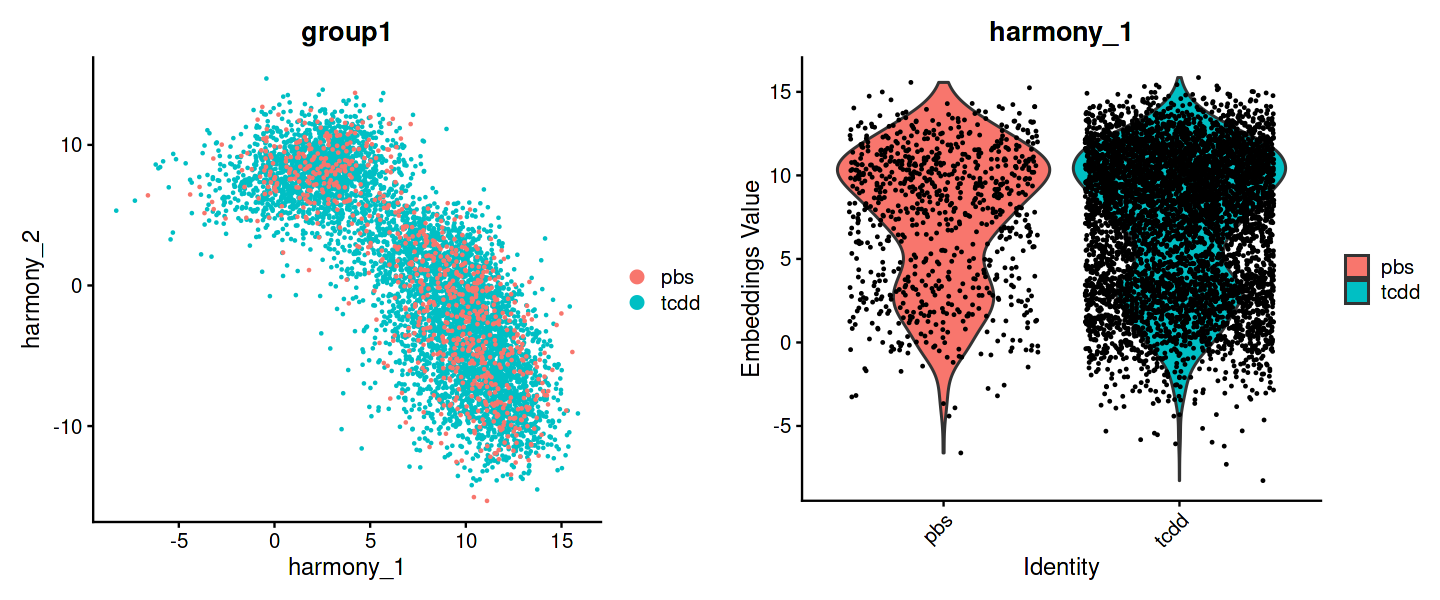

In [37]:
##subset tcdd and pbs#####
selected_identname <- "group1"
selected_ident <- c("tcdd","pbs")
selected_rownumbers <- which(merged_counts_perturb1[[]][,selected_identname] %in% selected_ident)
selected_cells <- rownames(merged_counts_perturb1[[]][selected_rownumbers,])
merged_counts_perturb1_tcdd_pbs <- subset(merged_counts_perturb1, cells = selected_cells) # subset from previously selected cells
FeaturePlot(merged_counts_perturb1_tcdd_pbs, features = "nCount_RNA", min.cutoff = 1000)
###harmony
merged_counts_perturb1_tcdd_pbs <- merged_counts_perturb1_tcdd_pbs %>% 
    RunHarmony("group1", plot_convergence = TRUE)
merged_counts_perturb1_tcdd_pbs[[]]
harmony_embeddings <- Embeddings(merged_counts_perturb1_tcdd_pbs, 'harmony')
harmony_embeddings[1:5, 1:5]
options(repr.plot.height = 5, repr.plot.width = 12)
p1 <- DimPlot(object = merged_counts_perturb1_tcdd_pbs, reduction = "harmony", pt.size = .1, group.by = "group1")
p2 <- VlnPlot(object = merged_counts_perturb1_tcdd_pbs, features = "harmony_1", group.by = "group1", pt.size = .1)
plot_grid(p1,p2)
merged_counts_perturb1_tcdd_pbs <- merged_counts_perturb1_tcdd_pbs %>% 
    RunUMAP(reduction = "harmony", dims = 1:20) %>% 
    FindNeighbors(reduction = "harmony", dims = 1:20) %>% 
    FindClusters(resolution = 0.5) %>% 
    identity()

In [ ]:
# save seurat object
saveRDS(merged_counts_perturb1_tcdd_pbs, file = "/data/tracy_data/perturbseq_qc_tcddafterharmony.rds")

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



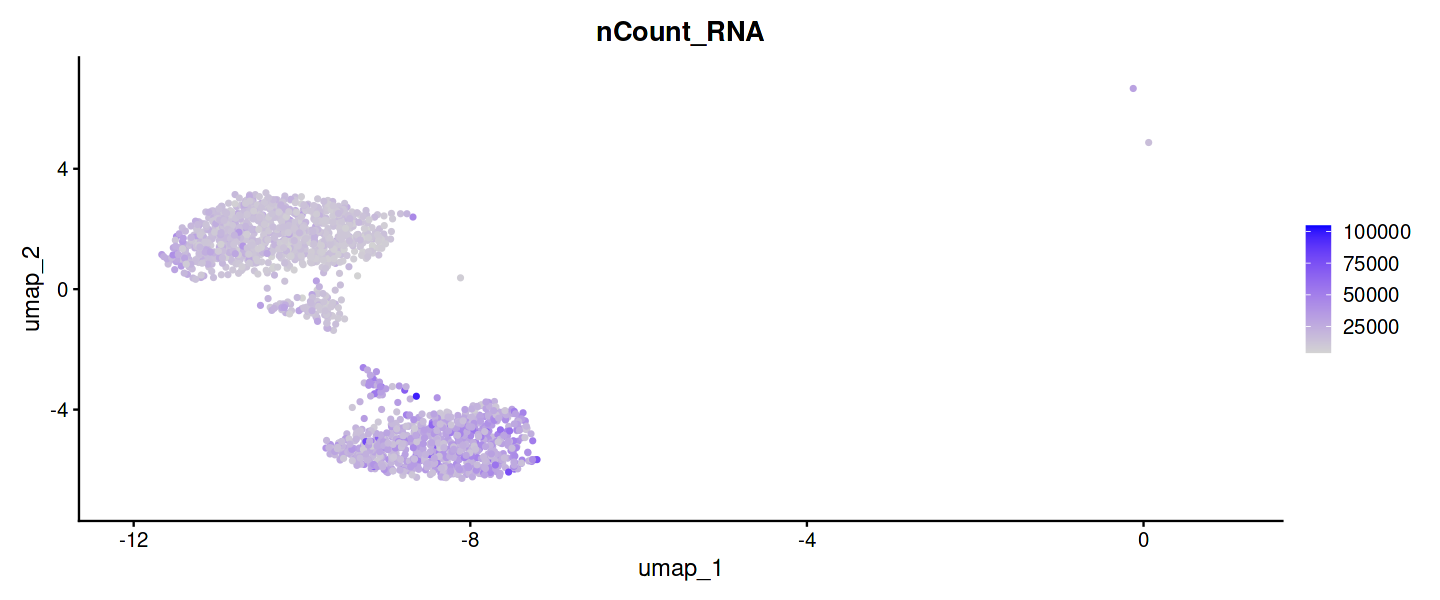

orig.ident nCount_RNA nFeature_RNA nCount_feature
AAACGAAGTTCCGGTG-2 2          35103      6319          683          
AAACGAATCCTCACTG-2 2          21186      5473         3207          
AAAGAACAGCCTCATA-2 2          31136      6671          449          
AAAGAACCACCCTTAC-2 2          36281      6984          614          
AAAGAACCATCGCCTT-2 2          36498      6146           59          
AAAGAACGTTGGAGAC-2 2          20884      5204          638          
AAAGGTACATCATTGG-2 2          22686      5457          330          
AAAGGTAGTGCACATT-2 2          24360      5551          695          
AAAGTGAAGCCATTGT-2 2          22762      5805          985          
AAAGTGAAGGGACCAT-2 2          22317      5110         1502          
AAATGGAAGGACTATA-2 2          13964      4268          550          
AACAACCAGTTACGAA-2 2          27807      6258          112          
AACAACCTCGCCAATA-2 2          28860      6218         1227          
AACAAGATCTAGTACG-2 2          15869      4364          363          
AACACACCACTCCGAG-2 2          26928      5814         1037          
AACACACGTTCGGCGT-2 2          35242      7205         1029          
AACAGGGCAGCTGGTC-2 2          33086      6534          756          
AACCACAAGTCCGTCG-2 2          27929      5789         1429          
AACCATGCACAAAGTA-2 2          35154      6579         1219          
AACCATGGTAACATCC-2 2          50323      7835          538          
AACCCAAAGCCTAGGA-2 2          36545      6814          437          
AACCTGATCCATTTCA-2 2          30819      6447          350          
AACGAAACATGAATCC-2 2          22074      5551         2368          
AACGAAAGTAAGATCA-2 2          18922      4508         5831          
AACGAAATCAAGCTTG-2 2          30703      6499         1389          
AACGAAATCCTTTGAT-2 2          32484      6180          328          
AACGGGACAGGGACTA-2 2          31307      6292          855          
AACGTCAAGGGCAGTT-2 2          68104      7791         1611          
AACTTCTAGCGTGTCC-2 2          19445      4792          192          
AACTTCTCATCTAGAC-2 2          27592      6094          394          
⋮                  ⋮          ⋮          ⋮            ⋮             
TTGCTGCGTAGCGTAG-1 1          13462      4105          218          
TTGCTGCTCACTGAAC-1 1          17538      4896         1050          
TTGCTGCTCGAAGCAG-1 1           9211      3374          246          
TTGGATGAGTGCAACG-1 1          11338      3581          964          
TTGGGTAAGAACTTCC-1 1           8083      2813          557          
TTGGGTATCCGAGTGC-1 1           8449      3011           49          
TTGGTTTCATCGATAC-1 1           8067      3007          258          
TTGTGGAAGCATATGA-1 1          14994      4375          549          
TTGTGGACACGGCCAT-1 1           9021      3173          936          
TTGTGTTTCCGACGGT-1 1           6726      2679          246          
TTGTTCAGTGGATGAC-1 1          13502      4300         1447          
TTGTTGTAGACCCGCT-1 1           9515      3352          573          
TTGTTGTTCGGTTCAA-1 1           6446      2736          168          
TTGTTTGCAGAGAGGG-1 1           9460      3356           59          
TTGTTTGCATGGGTTT-1 1          12576      3918           90          
TTTACCACATTGACCA-1 1           7081      2696          128          
TTTACTGCATAGAGGC-1 1          12182      3910           49          
TTTATGCAGCGATGGT-1 1          16508      4650          157          
TTTATGCGTCACCACG-1 1          13953      4043          115          
TTTCACACACCATAAC-1 1          18291      4956          501          
TTTCATGCAAGGTACG-1 1          10466      3325           52          
TTTCATGCACACCGAC-1 1          14387      4115         2238          
TTTCCTCAGGAACATT-1 1           8435      3165           87          
TTTGACTAGGACAAGA-1 1           8283      2824          377          
TTTGACTCAACAACAA-1 1          21260      5070          824          
TTTGACTTCACGGGCT-1 1          13138      4437          345          
TTTGATCCAGCGCTTG-

harmony_1 harmony_2  harmony_3  harmony_4 harmony_5 
AAACGAAGTTCCGGTG-2 -19.59021 -0.2719848  3.7840343 -2.493051 -0.7334286
AAACGAATCCTCACTG-2 -23.51389 -4.1346996 -1.0266157 -2.269727  0.6534207
AAAGAACAGCCTCATA-2 -23.72608 -1.6666508  0.4875674  7.092074 -0.9774697
AAAGAACCACCCTTAC-2 -21.91829 -0.5214388  1.3898735  6.722623 -0.3373175
AAAGAACCATCGCCTT-2 -20.08388  0.5987681  5.9306817 -3.193963 -1.2142407

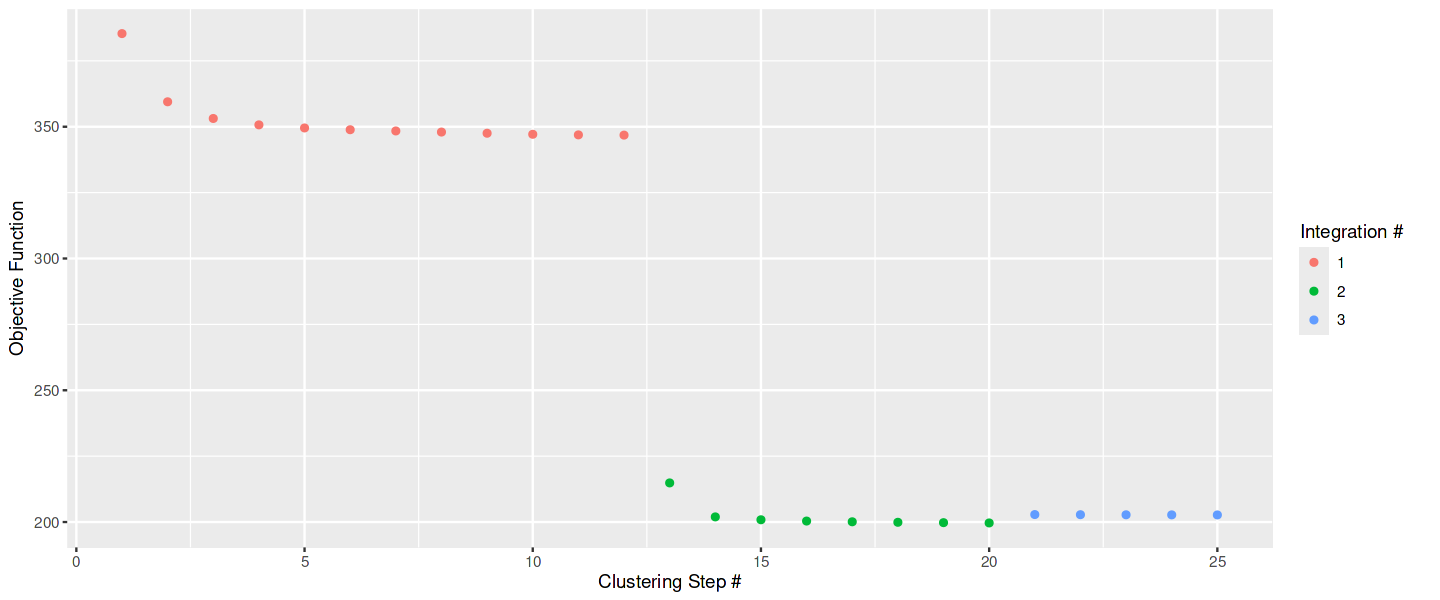

14:29:54 UMAP embedding parameters a = 0.9922 b = 1.112

14:29:54 Read 1920 rows and found 20 numeric columns

14:29:54 Using Annoy for neighbor search, n_neighbors = 30

14:29:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:29:55 Writing NN index file to temp file /tmp/RtmpTKAZbj/file8518471f70053

14:29:55 Searching Annoy index using 1 thread, search_k = 3000

14:29:55 Annoy recall = 100%

14:29:56 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:29:57 Initializing from normalized Laplacian + noise (using RSpectra)

14:29:57 Commencing optimization for 500 epochs, with 81434 positive edges

14:29:57 Using rng type: pcg

14:29:59 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1920
Number of edges: 68852

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6862
Number of communities: 5
Elapsed time: 0 seconds


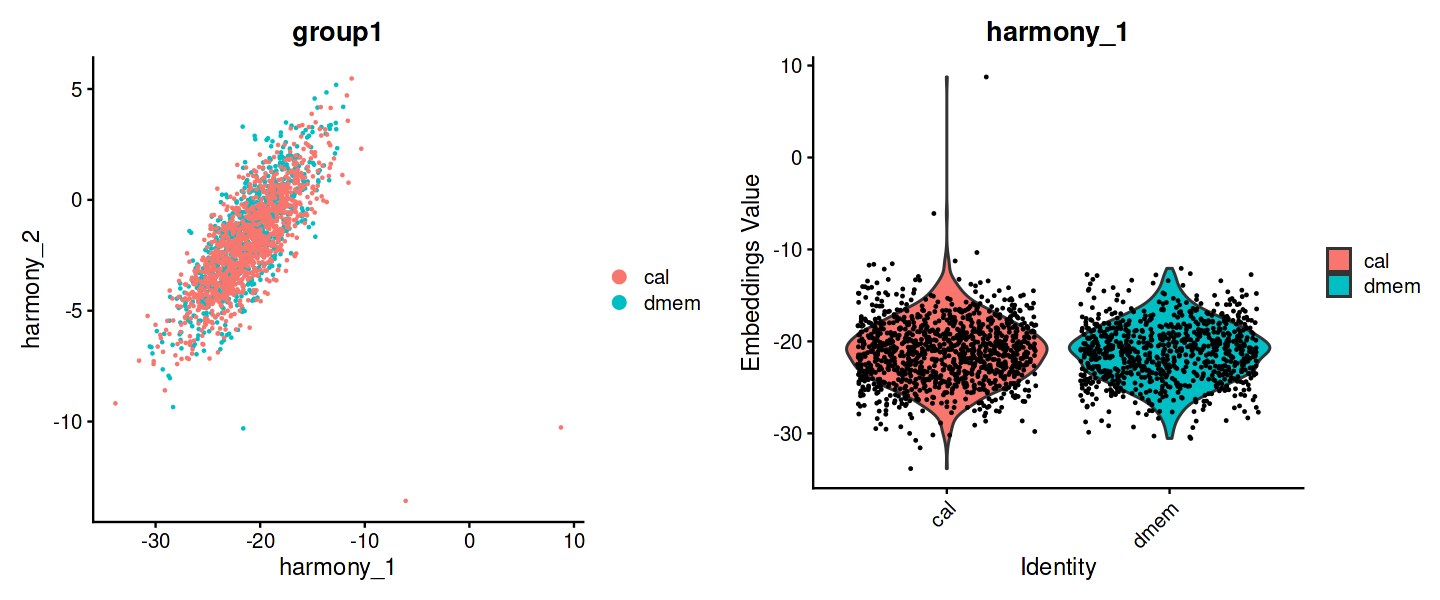

In [19]:
##subset cal and dmem#####
selected_identname <- "group1"
selected_ident <- c("cal","dmem")
selected_rownumbers <- which(merged_counts_perturb1[[]][,selected_identname] %in% selected_ident)
selected_cells <- rownames(merged_counts_perturb1[[]][selected_rownumbers,])
merged_counts_perturb1_cal_dmem <- subset(merged_counts_perturb1, cells = selected_cells) # subset from previously selected cells
FeaturePlot(merged_counts_perturb1_cal_dmem, features = "nCount_RNA", min.cutoff = 1000)
###harmony
merged_counts_perturb1_cal_dmem <- merged_counts_perturb1_cal_dmem %>% 
    RunHarmony("group1", plot_convergence = TRUE)
merged_counts_perturb1_cal_dmem[[]]
harmony_embeddings <- Embeddings(merged_counts_perturb1_cal_dmem, 'harmony')
harmony_embeddings[1:5, 1:5]
options(repr.plot.height = 5, repr.plot.width = 12)
p1 <- DimPlot(object = merged_counts_perturb1_cal_dmem, reduction = "harmony", pt.size = .1, group.by = "group1")
p2 <- VlnPlot(object = merged_counts_perturb1_cal_dmem, features = "harmony_1", group.by = "group1", pt.size = .1)
plot_grid(p1,p2)
merged_counts_perturb1_cal_dmem <- merged_counts_perturb1_cal_dmem %>% 
    RunUMAP(reduction = "harmony", dims = 1:20) %>% 
    FindNeighbors(reduction = "harmony", dims = 1:20) %>% 
    FindClusters(resolution = 0.5) %>% 
    identity()

In [ ]:
# save seurat object
saveRDS(merged_counts_perturb1_cal_dmem, file = "/data/tracy_data/perturbseq_qc_calcificationafterharmony.rds")

In [ ]:
########################################################################################################################

In [ ]:
### downstream analysis_add module score_ tcdd and pbs ###

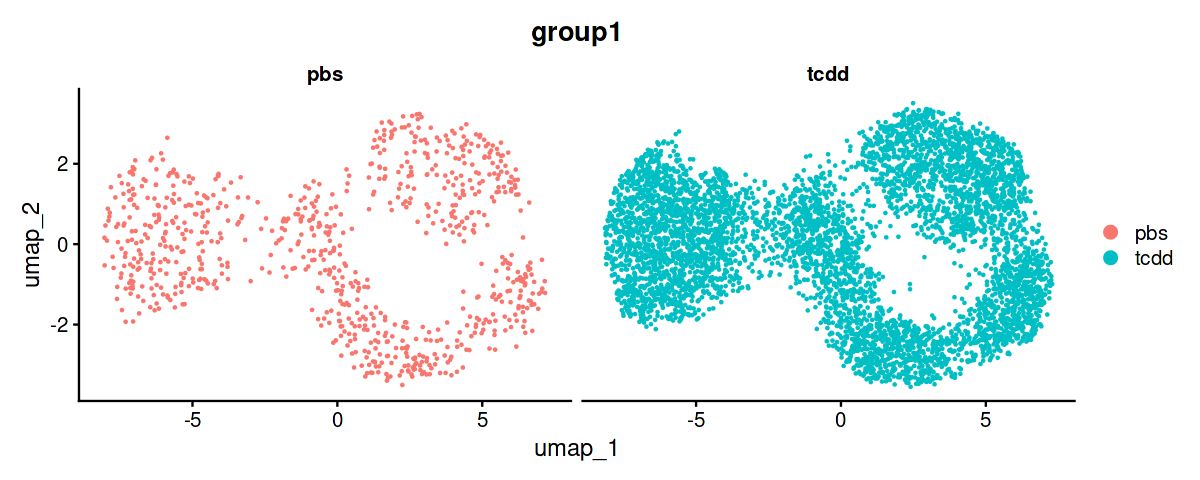

In [38]:
options(repr.plot.height = 4, repr.plot.width = 10)
DimPlot(merged_counts_perturb1_tcdd_pbs, reduction = "umap", group.by = "group1", pt.size = .1, split.by = 'group1')

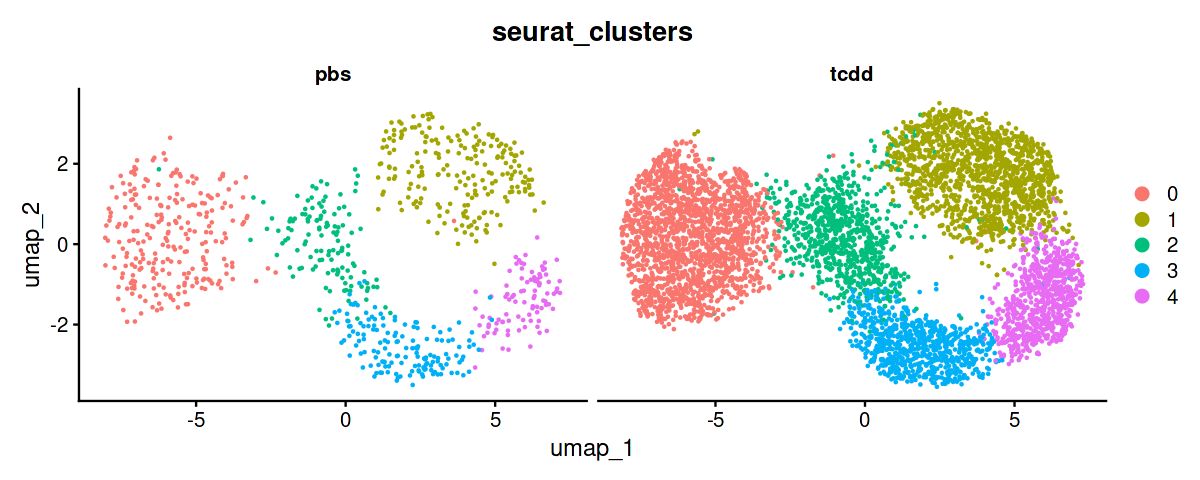

In [59]:
options(repr.plot.height = 4, repr.plot.width = 10)
        DimPlot(merged_counts_perturb1_tcdd_pbs, reduction = "umap", group.by = "seurat_clusters", pt.size = .1, split.by = 'group1')

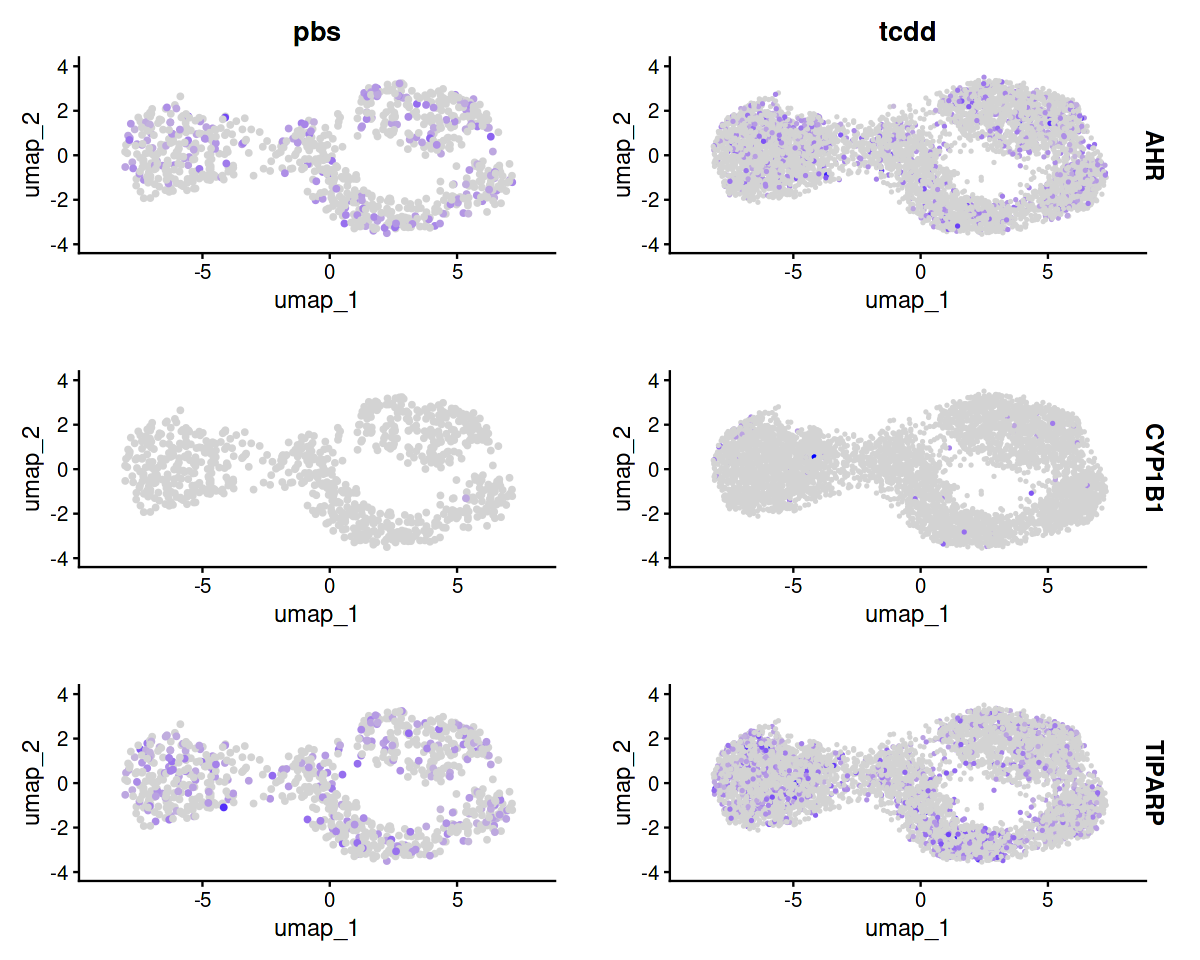

In [68]:
options(repr.plot.height = 8, repr.plot.width = 10)
FeaturePlot(merged_counts_perturb1_tcdd_pbs, features = c("AHR",
"CYP1B1",
"TIPARP"
), split.by = 'group1', ncol = 3)

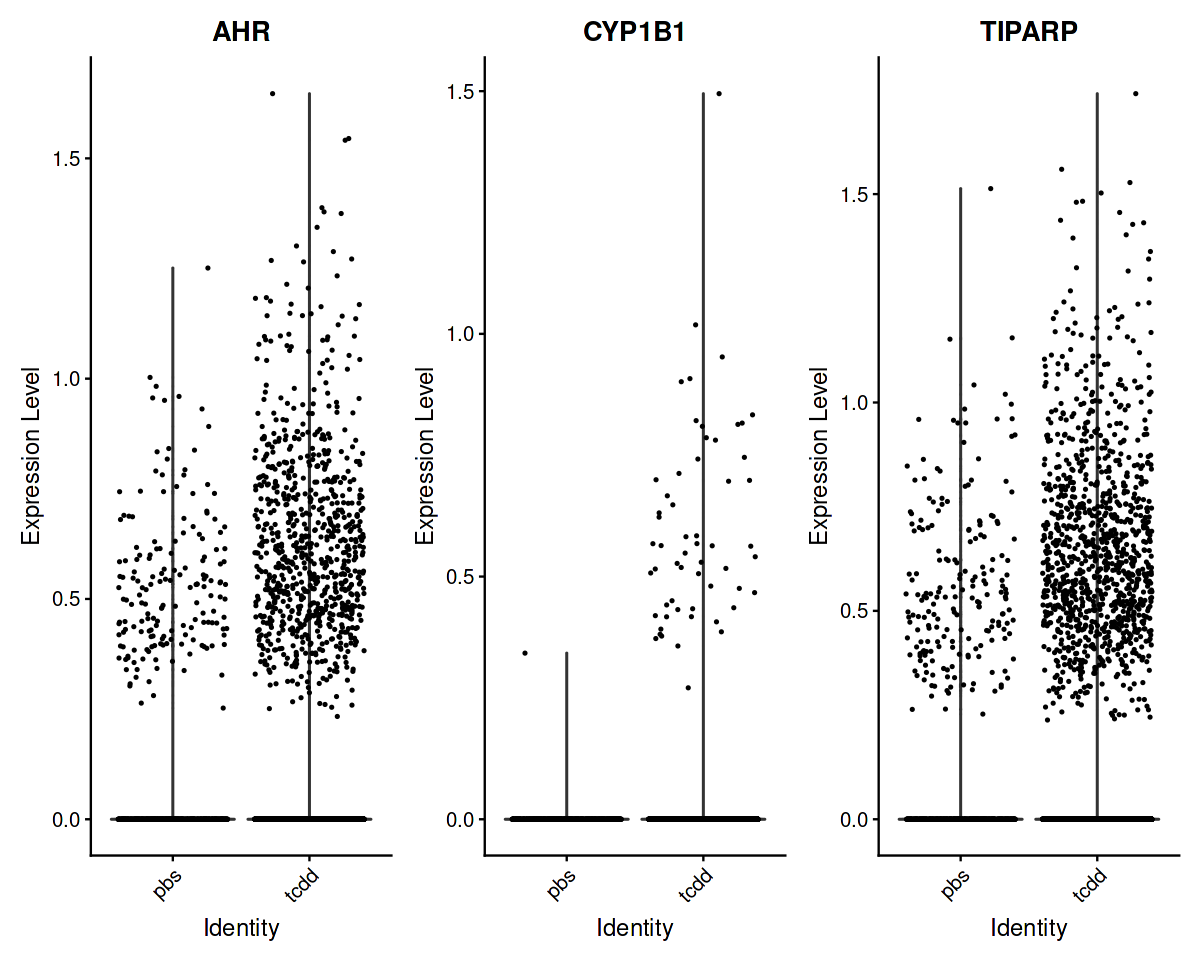

In [73]:
VlnPlot(
  merged_counts_perturb1_tcdd_pbs,
  features = c("AHR", "CYP1B1", "TIPARP"),
  group.by = "group1",
  pt.size = 0.2,
  combine = TRUE
)

In [40]:
table(merged_counts_perturb1_tcdd_pbs$group1)


 pbs tcdd 
 825 5483 

In [41]:
merged_counts_perturb1_tcdd_pbs[[]]

orig.ident nCount_RNA nFeature_RNA nCount_feature
AAACCCAAGTCACTGT-4 4          13948      4221          691          
AAACCCAAGTTGCTGT-4 4          10308      3900          128          
AAACCCACATCGCTGG-4 4           9955      3882          101          
AAACCCAGTGCCTAAT-4 4          13446      4572          164          
AAACCCATCATCGGGC-4 4          19663      5336          911          
AAACGAAAGCTTGTGT-4 4           7693      3175          532          
AAACGAACAAACTCGT-4 4          15810      5054          471          
AAACGAACACTGTGTA-4 4          14097      4161           54          
AAACGAACAGAACATA-4 4           9462      3421           77          
AAACGAAGTAGCGCCT-4 4          14906      4935         1578          
AAACGAAGTATATGGA-4 4          12293      4200          325          
AAACGAATCTTTGCGC-4 4           7053      2913          191          
AAACGCTAGACATCAA-4 4           6667      3038          741          
AAACGCTAGACGAAGA-4 4          12395      4241          220          
AAACGCTCAACTCGAT-4 4          10762      4030         1058          
AAACGCTGTAGCCAGA-4 4          19626      5208          273          
AAACGCTTCTCTATGT-4 4           7629      3459          601          
AAACGCTTCTGCCCTA-4 4           8699      3516          391          
AAAGAACAGGCTAAAT-4 4          12850      4000          710          
AAAGAACAGGGATCTG-4 4           6759      2611          255          
AAAGAACCAAATCCCA-4 4           8968      3716         1051          
AAAGAACCAGACGCTC-4 4          12344      4459          307          
AAAGAACTCACCTCGT-4 4          14369      4840          752          
AAAGAACTCCAATCTT-4 4           8244      3361          451          
AAAGAACTCCCTATTA-4 4           5280      2607          348          
AAAGAACTCCTCTTTC-4 4           8233      3138           45          
AAAGAACTCGCATTAG-4 4           8525      3299          145          
AAAGGATCACTTGGGC-4 4           7724      2899          773          
AAAGGATCATTGACCA-4 4           9727      3610          742          
AAAGGATGTAAGTAGT-4 4           6775      2836          677          
⋮                  ⋮          ⋮          ⋮            ⋮             
TTCTAACTCGTTCAGA-3 3           6232      2743          432          
TTCTAGTAGCACCGAA-3 3          18493      5514          829          
TTCTAGTCAGCAAGAC-3 3          21586      6002          169          
TTCTGTACATCATTTC-3 3           9332      3659          841          
TTCTTCCCACCTGCGA-3 3          13278      4655          285          
TTCTTCCTCAAGCCCG-3 3          14202      4861           84          
TTCTTGAAGCCATATC-3 3           6301      3013          230          
TTCTTGAAGCGACTTT-3 3           9899      4182           74          
TTGAACGGTGACATCT-3 3           9964      3468         1026          
TTGAGTGAGTAGACCG-3 3          11640      4354          139          
TTGCATTGTAGATTGA-3 3          10784      3688          362          
TTGCATTTCGCGGACT-3 3          24332      5884          160          
TTGCCTGCAAAGCTAA-3 3          15992      4325          599          
TTGGATGGTATCCCTC-3 3          16410      4397           22          
TTGGGCGGTGGTTTGT-3 3          21177      5838         1059          
TTGGGCGTCGGAATTC-3 3          10677      3575          803          
TTGGTTTTCCATTCGC-3 3           9553      3935          666          
TTGTTCAGTGGCTCTG-3 3           8130      3425          244          
TTGTTGTGTGATGTAA-3 3           8819      3024          603          
TTGTTTGAGATTTGCC-3 3           8181      3343          345          
TTGTTTGAGCGTGCTC-3 3           8304      3189          600          
TTGTTTGTCTAGTGAC-3 3          10162      3765          648          
TTTACTGAGTCAATCC-3 3          14453      4646          956          
TTTAGTCCATGTGCCG-3 3          10284      3718          237          
TTTATGCCAACCTATG-3 3           8621      3359          698          
TTTCACAAGACTGTTC-3 3          11762      3642          601          
TTTGACTAGTATTCCG-

orig.ident nCount_RNA nFeature_RNA nCount_feature
AAACCCAAGTCACTGT-4 4          13948      4221          691          
AAACCCAAGTTGCTGT-4 4          10308      3900          128          
AAACCCACATCGCTGG-4 4           9955      3882          101          
AAACCCAGTGCCTAAT-4 4          13446      4572          164          
AAACCCATCATCGGGC-4 4          19663      5336          911          
AAACGAAAGCTTGTGT-4 4           7693      3175          532          
AAACGAACAAACTCGT-4 4          15810      5054          471          
AAACGAACACTGTGTA-4 4          14097      4161           54          
AAACGAACAGAACATA-4 4           9462      3421           77          
AAACGAAGTAGCGCCT-4 4          14906      4935         1578          
                   nFeature_feature group group1 percent.mt RNA_snn_res.0.5
AAACCCAAGTCACTGT-4 20               4     tcdd   3.491540   0              
AAACCCAAGTTGCTGT-4  9               4     tcdd   4.006597   4              
AAACCCACATCGCTGG-4 14               4     tcdd   3.043697   2              
AAACCCAGTGCCTAAT-4 19               4     tcdd   3.986316   2              
AAACCCATCATCGGGC-4  7               4     tcdd   3.173473   1              
AAACGAAAGCTTGTGT-4 18               4     tcdd   4.627584   1              
AAACGAACAAACTCGT-4 19               4     tcdd   4.130297   4              
AAACGAACACTGTGTA-4 14               4     tcdd   4.405193   0              
AAACGAACAGAACATA-4 24               4     tcdd   2.906362   3              
AAACGAAGTAGCGCCT-4 23               4     tcdd   5.239501   1              
                   seurat_clusters cell_barcode num_features
AAACCCAAGTCACTGT-4 0               2922         2           
AAACCCAAGTTGCTGT-4 4               2923         2           
AAACCCACATCGCTGG-4 2               2925         1           
AAACCCAGTGCCTAAT-4 2               2926         2           
AAACCCATCATCGGGC-4 1               2927         2           
AAACGAAAGCTTGTGT-4 1               2928         2           
AAACGAACAAACTCGT-4 4               2929         2           
AAACGAACACTGTGTA-4 0               2931         1           
AAACGAACAGAACATA-4 3               2932         2           
AAACGAAGTAGCGCCT-4 1               2933         2           
                   feature_call          num_umis guide    modulation_score1
AAACCCAAGTCACTGT-4 TIPARP-1|TIPARP-5     271|401  TIPARP    0.211029058     
AAACCCAAGTTGCTGT-4 SMARCA4-2|SMARCA4-5   49|70    SMARCA4   0.162803115     
AAACCCACATCGCTGG-4 SMARCA4-1             67       SMARCA4  -0.073597879     
AAACCCAGTGCCTAAT-4 SMAD3-2|SMAD3-5       116|27   SMAD3     0.055965571     
AAACCCATCATCGGGC-4 TWIST1-2|TWIST1-5     566|361  TWIST1    0.212304543     
AAACGAAAGCTTGTGT-4 TIPARP-1|TIPARP-5     195|314  TIPARP    0.086425094     
AAACGAACAAACTCGT-4 NFE2L2-1|NFE2L2-4     283|163  NFE2L2    0.128944394     
AAACGAACACTGTGTA-4 HSP90AA1-5            36       HSP90AA1  0.119765638     
AAACGAACAGAACATA-4 HSP90AA1-1|NEG_CTRL-3 32|5     HSP90AA1 -0.006832155     
AAACGAAGTAGCGCCT-4 SMARCA4-1|SMARCA4-4   991|583  SMARCA4   0.176385834

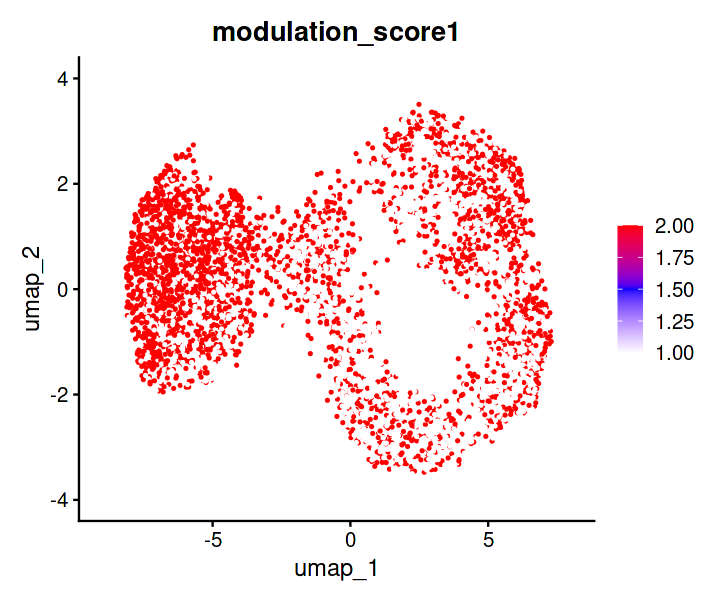

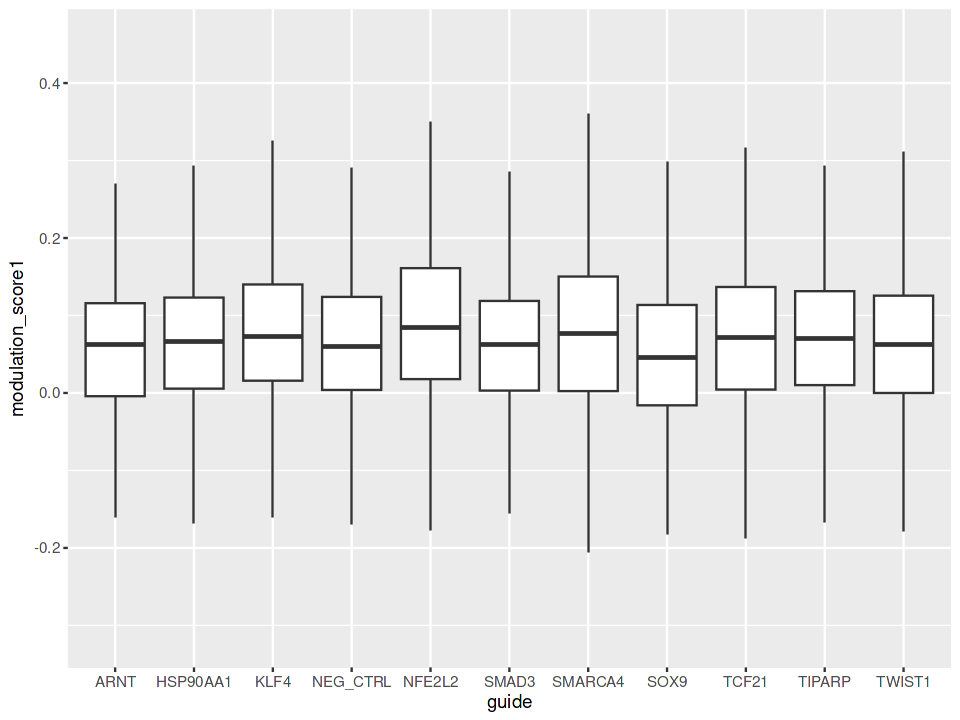

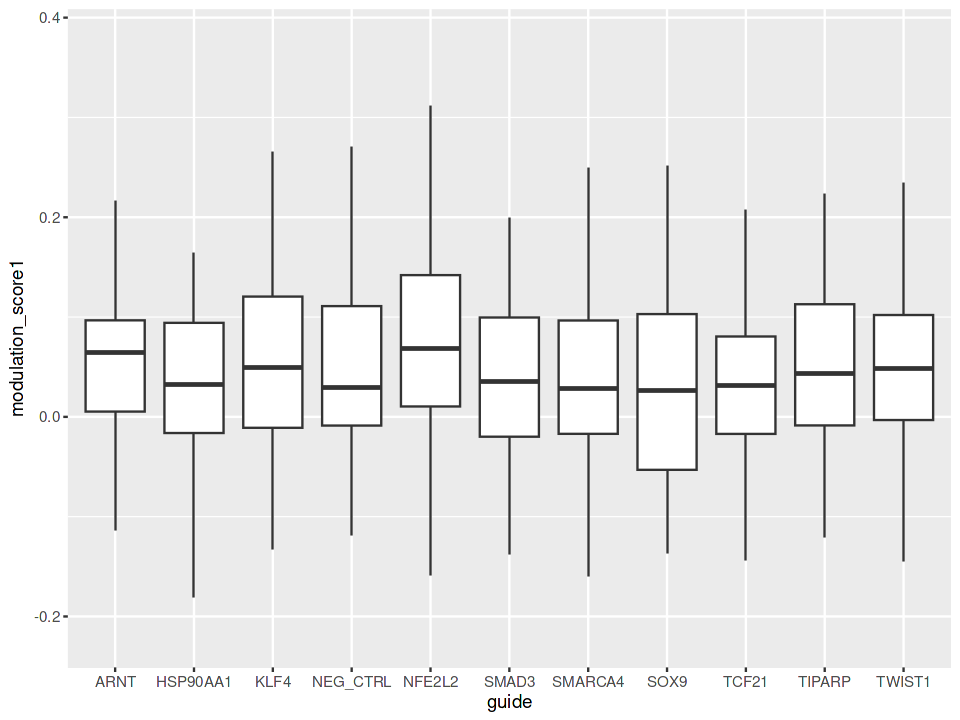

In [42]:
###Addmodule score
##Calculate modulation scores for feature expression programs in single cells
cd_features <- list(c("BMP2", "ALPL","NAB2","PEX7","MGP","SMPD3","SOX9","RUNX2","COL2A1","ACAN","COL1A1","MEF2C","MMP2"))
merged_counts_perturb1_tcdd_pbs <- AddModuleScore(
  object = merged_counts_perturb1_tcdd_pbs,
  features = cd_features,
  ctrl = 5,
  name = 'modulation_score',
    seed = 1
)
head(x = merged_counts_perturb1_tcdd_pbs[])
my_palette <- c("white", "blue", "red")
names(my_palette) <- c("0", "1", "2")
options(repr.plot.height = 5, repr.plot.width = 6)
Idents(merged_counts_perturb1_tcdd_pbs) <- 'modulation_score1'
FeaturePlot(merged_counts_perturb1_tcdd_pbs, features = "modulation_score1", cols = my_palette)
Idents(merged_counts_perturb1_tcdd_pbs)<-merged_counts_perturb1_tcdd_pbs$group1
subset(merged_counts_perturb1_tcdd_pbs,idents = c('tcdd'))->tcdd
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(tcdd@meta.data, aes(x = guide, y = modulation_score1)) +
  geom_boxplot(outlier.shape = NA)

Idents(merged_counts_perturb1_tcdd_pbs)<-merged_counts_perturb1_tcdd_pbs$group1
subset(merged_counts_perturb1_tcdd_pbs,idents = c('pbs'))->pbs
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(pbs@meta.data, aes(x = guide, y = modulation_score1)) +
  geom_boxplot(outlier.shape = NA)

Warning message:
“The following features are not present in the object: AC020571.3, not searching for symbol synonyms”


orig.ident nCount_RNA nFeature_RNA nCount_feature
AAACCCAAGTCACTGT-4 4          13948      4221          691          
AAACCCAAGTTGCTGT-4 4          10308      3900          128          
AAACCCACATCGCTGG-4 4           9955      3882          101          
AAACCCAGTGCCTAAT-4 4          13446      4572          164          
AAACCCATCATCGGGC-4 4          19663      5336          911          
AAACGAAAGCTTGTGT-4 4           7693      3175          532          
AAACGAACAAACTCGT-4 4          15810      5054          471          
AAACGAACACTGTGTA-4 4          14097      4161           54          
AAACGAACAGAACATA-4 4           9462      3421           77          
AAACGAAGTAGCGCCT-4 4          14906      4935         1578          
                   nFeature_feature group group1 percent.mt RNA_snn_res.0.5
AAACCCAAGTCACTGT-4 20               4     tcdd   3.491540   0              
AAACCCAAGTTGCTGT-4  9               4     tcdd   4.006597   4              
AAACCCACATCGCTGG-4 14               4     tcdd   3.043697   2              
AAACCCAGTGCCTAAT-4 19               4     tcdd   3.986316   2              
AAACCCATCATCGGGC-4  7               4     tcdd   3.173473   1              
AAACGAAAGCTTGTGT-4 18               4     tcdd   4.627584   1              
AAACGAACAAACTCGT-4 19               4     tcdd   4.130297   4              
AAACGAACACTGTGTA-4 14               4     tcdd   4.405193   0              
AAACGAACAGAACATA-4 24               4     tcdd   2.906362   3              
AAACGAAGTAGCGCCT-4 23               4     tcdd   5.239501   1              
                   seurat_clusters cell_barcode num_features
AAACCCAAGTCACTGT-4 0               2922         2           
AAACCCAAGTTGCTGT-4 4               2923         2           
AAACCCACATCGCTGG-4 2               2925         1           
AAACCCAGTGCCTAAT-4 2               2926         2           
AAACCCATCATCGGGC-4 1               2927         2           
AAACGAAAGCTTGTGT-4 1               2928         2           
AAACGAACAAACTCGT-4 4               2929         2           
AAACGAACACTGTGTA-4 0               2931         1           
AAACGAACAGAACATA-4 3               2932         2           
AAACGAAGTAGCGCCT-4 1               2933         2           
                   feature_call          num_umis guide    modulation_score1
AAACCCAAGTCACTGT-4 TIPARP-1|TIPARP-5     271|401  TIPARP    0.211029058     
AAACCCAAGTTGCTGT-4 SMARCA4-2|SMARCA4-5   49|70    SMARCA4   0.162803115     
AAACCCACATCGCTGG-4 SMARCA4-1             67       SMARCA4  -0.073597879     
AAACCCAGTGCCTAAT-4 SMAD3-2|SMAD3-5       116|27   SMAD3     0.055965571     
AAACCCATCATCGGGC-4 TWIST1-2|TWIST1-5     566|361  TWIST1    0.212304543     
AAACGAAAGCTTGTGT-4 TIPARP-1|TIPARP-5     195|314  TIPARP    0.086425094     
AAACGAACAAACTCGT-4 NFE2L2-1|NFE2L2-4     283|163  NFE2L2    0.128944394     
AAACGAACACTGTGTA-4 HSP90AA1-5            36       HSP90AA1  0.119765638     
AAACGAACAGAACATA-4 HSP90AA1-1|NEG_CTRL-3 32|5     HSP90AA1 -0.006832155     
AAACGAAGTAGCGCCT-4 SMARCA4-1|SMARCA4-4   991|583  SMARCA4   0.176385834     
                   ahr_score1  
AAACCCAAGTCACTGT-4  0.032123037
AAACCCAAGTTGCTGT-4 -0.051256434
AAACCCACATCGCTGG-4  0.065981181
AAACCCAGTGCCTAAT-4 -0.045349059
AAACCCATCATCGGGC-4 -0.009174262
AAACGAAAGCTTGTGT-4 -0.039783617
AAACGAACAAACTCGT-4  0.019855857
AAACGAACACTGTGTA-4  0.037189364
AAACGAACAGAACATA-4  0.015182738
AAACGAAGTAGCGCCT-4  0.030423524

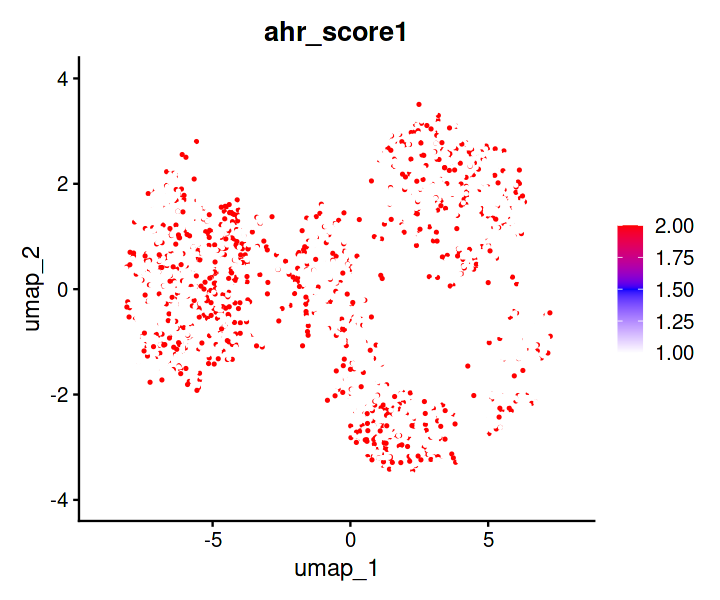

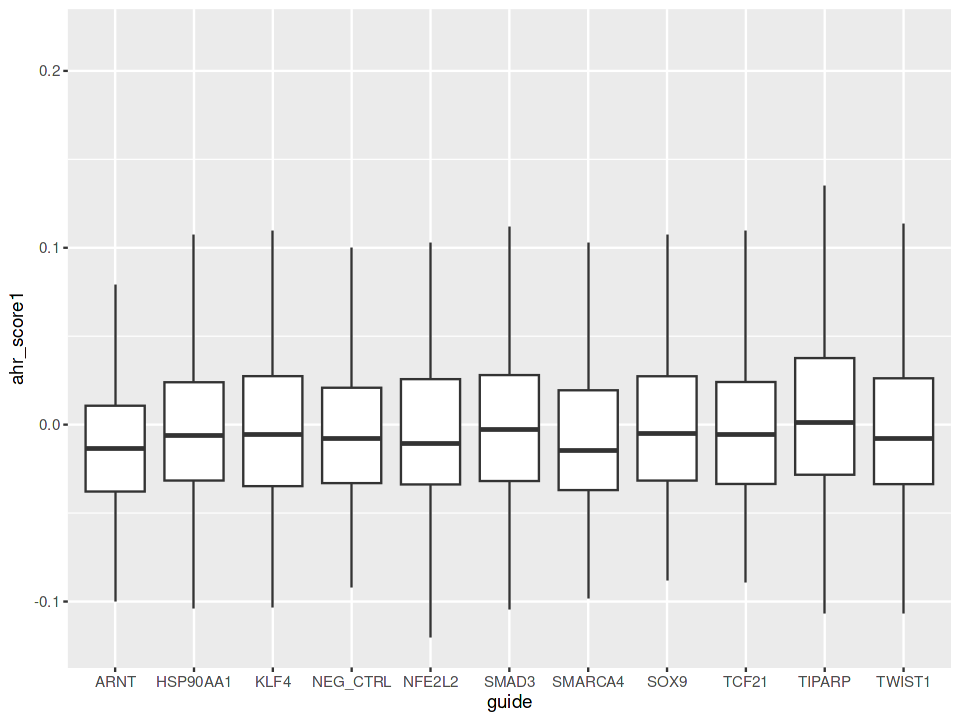

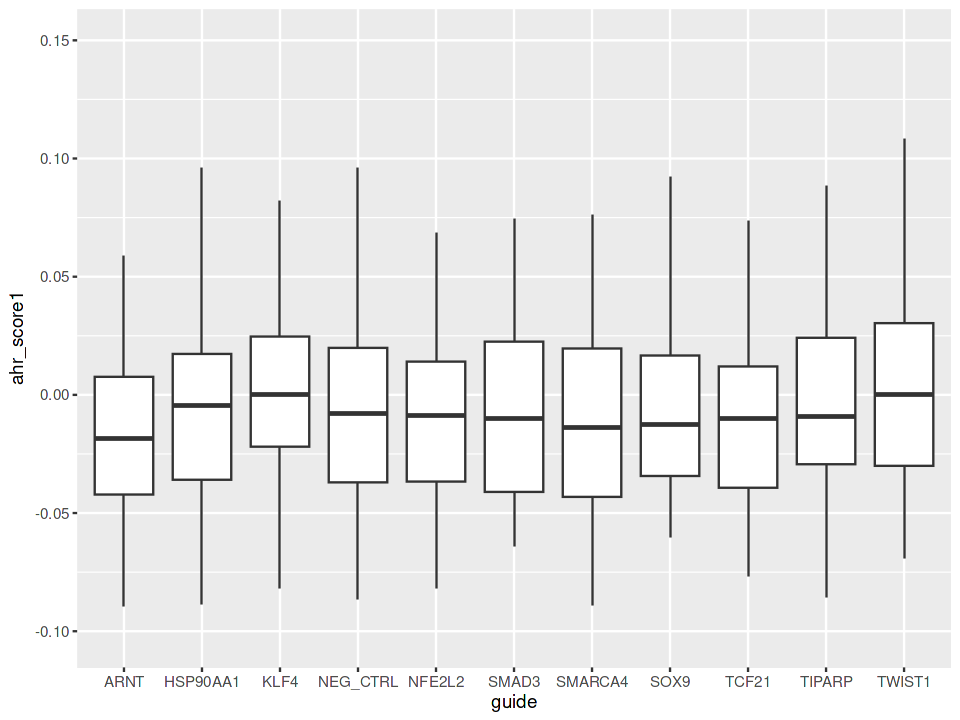

In [43]:
##Calculate ahr scores for feature expression programs in single cells
cd_features <- list(c('AHR', 'P2RX1', 'CLDN14', 'CYP1A1', 'C3orf80', 'EFCAB12', 'RGCC', 'RASL11B', 'IL11', 'IGF1', 'COL7A1', 'NFATC2', 'RIN1', 'GPR68', 'PTGS2', 'AC020571.3', 'AP001007.1', 'SLAMF9', 'PENK', 'AC018755.1'))
merged_counts_perturb1_tcdd_pbs <- AddModuleScore(
  object = merged_counts_perturb1_tcdd_pbs,
  features = cd_features,
  ctrl = 5,
  name = 'ahr_score',
    seed = 1
)

head(x = merged_counts_perturb1_tcdd_pbs[])
my_palette <- c("white", "blue", "red")
names(my_palette) <- c("0", "1", "2")
options(repr.plot.height = 5, repr.plot.width = 6)

Idents(merged_counts_perturb1_tcdd_pbs) <- 'ahr_score1'
FeaturePlot(merged_counts_perturb1_tcdd_pbs, features = "ahr_score1", cols = my_palette)
Idents(merged_counts_perturb1_tcdd_pbs)<-merged_counts_perturb1_tcdd_pbs$group1
subset(merged_counts_perturb1_tcdd_pbs,idents = c('tcdd'))->tcdd
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(tcdd@meta.data, aes(x = guide, y = ahr_score1)) +
  geom_boxplot(outlier.shape = NA)

Idents(merged_counts_perturb1_tcdd_pbs)<-merged_counts_perturb1_tcdd_pbs$group1
subset(merged_counts_perturb1_tcdd_pbs,idents = c('pbs'))->pbs
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(pbs@meta.data, aes(x = guide, y = ahr_score1)) +
  geom_boxplot(outlier.shape = NA)

Warning message:
“The following features are not present in the object: MIR124-1, MIR4635, not searching for symbol synonyms”


orig.ident nCount_RNA nFeature_RNA nCount_feature
AAACCCAAGTCACTGT-4 4          13948      4221          691          
AAACCCAAGTTGCTGT-4 4          10308      3900          128          
AAACCCACATCGCTGG-4 4           9955      3882          101          
AAACCCAGTGCCTAAT-4 4          13446      4572          164          
AAACCCATCATCGGGC-4 4          19663      5336          911          
AAACGAAAGCTTGTGT-4 4           7693      3175          532          
AAACGAACAAACTCGT-4 4          15810      5054          471          
AAACGAACACTGTGTA-4 4          14097      4161           54          
AAACGAACAGAACATA-4 4           9462      3421           77          
AAACGAAGTAGCGCCT-4 4          14906      4935         1578          
                   nFeature_feature group group1 percent.mt RNA_snn_res.0.5
AAACCCAAGTCACTGT-4 20               4     tcdd   3.491540   0              
AAACCCAAGTTGCTGT-4  9               4     tcdd   4.006597   4              
AAACCCACATCGCTGG-4 14               4     tcdd   3.043697   2              
AAACCCAGTGCCTAAT-4 19               4     tcdd   3.986316   2              
AAACCCATCATCGGGC-4  7               4     tcdd   3.173473   1              
AAACGAAAGCTTGTGT-4 18               4     tcdd   4.627584   1              
AAACGAACAAACTCGT-4 19               4     tcdd   4.130297   4              
AAACGAACACTGTGTA-4 14               4     tcdd   4.405193   0              
AAACGAACAGAACATA-4 24               4     tcdd   2.906362   3              
AAACGAAGTAGCGCCT-4 23               4     tcdd   5.239501   1              
                   seurat_clusters cell_barcode num_features
AAACCCAAGTCACTGT-4 0               2922         2           
AAACCCAAGTTGCTGT-4 4               2923         2           
AAACCCACATCGCTGG-4 2               2925         1           
AAACCCAGTGCCTAAT-4 2               2926         2           
AAACCCATCATCGGGC-4 1               2927         2           
AAACGAAAGCTTGTGT-4 1               2928         2           
AAACGAACAAACTCGT-4 4               2929         2           
AAACGAACACTGTGTA-4 0               2931         1           
AAACGAACAGAACATA-4 3               2932         2           
AAACGAAGTAGCGCCT-4 1               2933         2           
                   feature_call          num_umis guide    modulation_score1
AAACCCAAGTCACTGT-4 TIPARP-1|TIPARP-5     271|401  TIPARP    0.211029058     
AAACCCAAGTTGCTGT-4 SMARCA4-2|SMARCA4-5   49|70    SMARCA4   0.162803115     
AAACCCACATCGCTGG-4 SMARCA4-1             67       SMARCA4  -0.073597879     
AAACCCAGTGCCTAAT-4 SMAD3-2|SMAD3-5       116|27   SMAD3     0.055965571     
AAACCCATCATCGGGC-4 TWIST1-2|TWIST1-5     566|361  TWIST1    0.212304543     
AAACGAAAGCTTGTGT-4 TIPARP-1|TIPARP-5     195|314  TIPARP    0.086425094     
AAACGAACAAACTCGT-4 NFE2L2-1|NFE2L2-4     283|163  NFE2L2    0.128944394     
AAACGAACACTGTGTA-4 HSP90AA1-5            36       HSP90AA1  0.119765638     
AAACGAACAGAACATA-4 HSP90AA1-1|NEG_CTRL-3 32|5     HSP90AA1 -0.006832155     
AAACGAAGTAGCGCCT-4 SMARCA4-1|SMARCA4-4   991|583  SMARCA4   0.176385834     
                   ahr_score1   tcdd_score1 
AAACCCAAGTCACTGT-4  0.032123037 -0.006006096
AAACCCAAGTTGCTGT-4 -0.051256434  0.059916190
AAACCCACATCGCTGG-4  0.065981181  0.045747744
AAACCCAGTGCCTAAT-4 -0.045349059 -0.018533941
AAACCCATCATCGGGC-4 -0.009174262 -0.018273857
AAACGAAAGCTTGTGT-4 -0.039783617  0.027761942
AAACGAACAAACTCGT-4  0.019855857 -0.010891541
AAACGAACACTGTGTA-4  0.037189364  0.004200073
AAACGAACAGAACATA-4  0.015182738  0.047074750
AAACGAAGTAGCGCCT-4  0.030423524  0.045474661

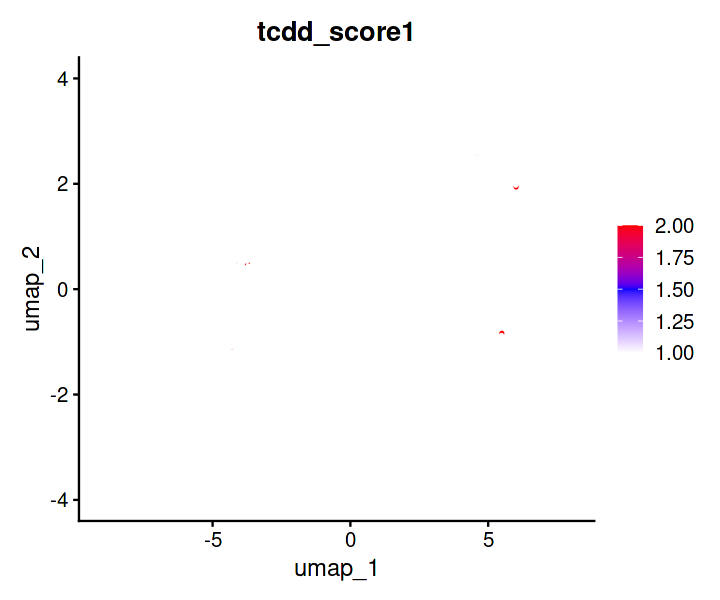

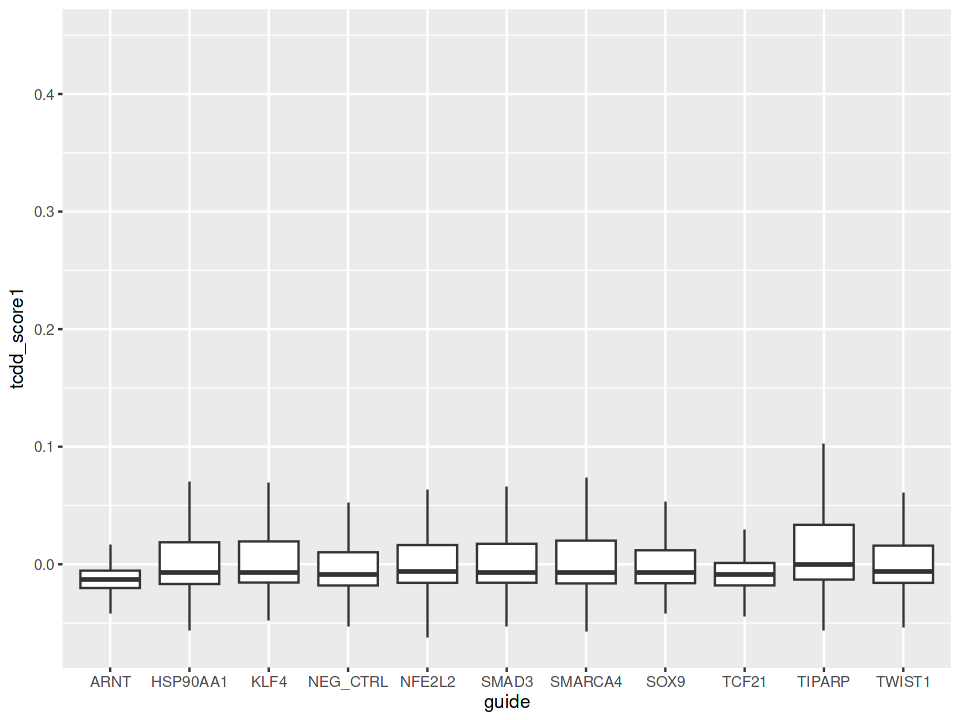

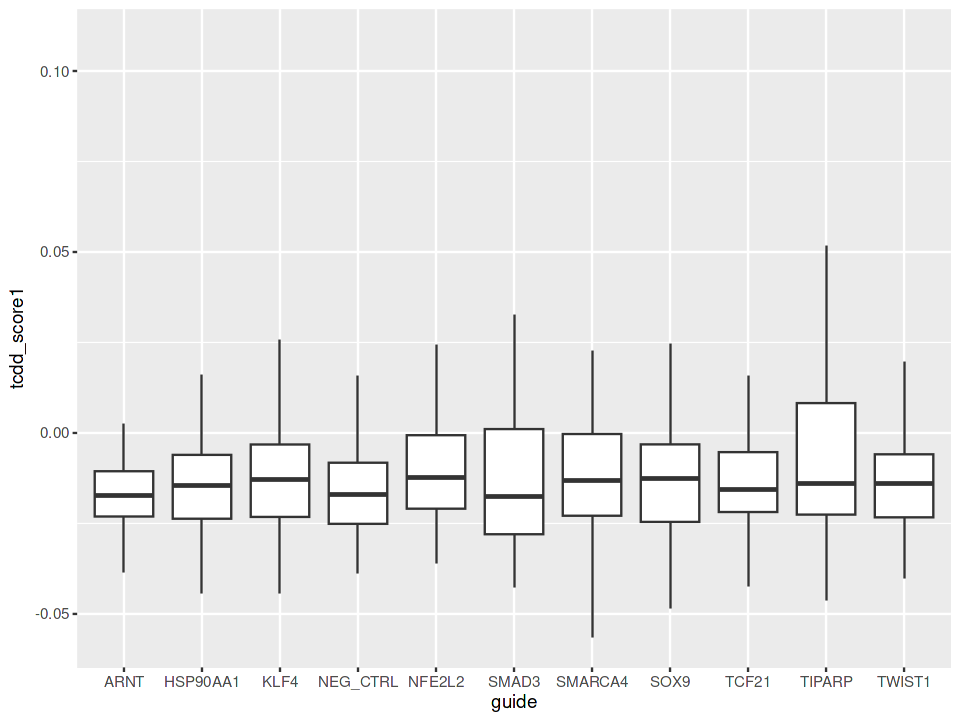

In [44]:
##Calculate TCDD scores for feature expression programs in single cells
cd_features <- list(c('NPTX1', 'ATP1B2', 'CYP1A1', 'CD7', 'HS3ST2', 'FGF18', 'PDK4', 'F2RL3', 'NKAIN1', 'ERBB4', 'IL1RN', 'MIR124-1','OLFM2', 'MIR4635', 'NKD2','CYP1B1', 'SLC16A6', 'SECTM1', 'FENDRR', 'ABCG2'))
merged_counts_perturb1_tcdd_pbs <- AddModuleScore(
  object = merged_counts_perturb1_tcdd_pbs,
  features = cd_features,
  ctrl = 5,
  name = 'tcdd_score',
    seed = 1
)
head(x = merged_counts_perturb1_tcdd_pbs[])
my_palette <- c("white", "blue", "red")
names(my_palette) <- c("0", "1", "2")
options(repr.plot.height = 5, repr.plot.width = 6)

Idents(merged_counts_perturb1_tcdd_pbs) <- 'tcdd_score1'
FeaturePlot(merged_counts_perturb1_tcdd_pbs, features = "tcdd_score1", cols = my_palette)
Idents(merged_counts_perturb1_tcdd_pbs)<-merged_counts_perturb1_tcdd_pbs$group1
subset(merged_counts_perturb1_tcdd_pbs,idents = c('tcdd'))->tcdd
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(tcdd@meta.data, aes(x = guide, y = tcdd_score1)) +
  geom_boxplot(outlier.shape = NA)

Idents(merged_counts_perturb1_tcdd_pbs)<-merged_counts_perturb1_tcdd_pbs$group1
subset(merged_counts_perturb1_tcdd_pbs,idents = c('pbs'))->pbs
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(pbs@meta.data, aes(x = guide, y = tcdd_score1)) +
  geom_boxplot(outlier.shape = NA)

In [45]:
###calculate p values for tcdd cells
library(dplyr)
meta <- tcdd@meta.data

In [46]:
# 设置列名
score_col <- "modulation_score1"
guide_col <- "guide"
control_label <- "NEG_CTRL"   # 改成你的control名称

# 提取control
meta_ctrl <- meta %>% filter(!!sym(guide_col) == control_label)

# 获取所有其他guide
guides <- setdiff(unique(meta[[guide_col]]), control_label)

# 结果表
res <- data.frame(guide = guides, p_value = NA, median_diff = NA)

# 循环做Wilcoxon
for (g in guides) {
  meta_g <- meta %>% filter(!!sym(guide_col) == g)
  test <- wilcox.test(meta_g[[score_col]], meta_ctrl[[score_col]], exact = FALSE)
  res[res$guide == g, "p_value"] <- test$p.value
  res[res$guide == g, "median_diff"] <- median(meta_g[[score_col]], na.rm = TRUE) - median(meta_ctrl[[score_col]], na.rm = TRUE)
}

# BH校正
res$FDR <- p.adjust(res$p_value, method = "BH")

# 排序
res <- res %>% arrange(p_value)
print(res)

      guide    p_value  median_diff        FDR
1    NFE2L2 0.00101194  0.024768942 0.01011940
2      SOX9 0.01762957 -0.013972698 0.06485896
3   SMARCA4 0.01945769  0.017360693 0.06485896
4      KLF4 0.02677024  0.013673791 0.06692561
5    TIPARP 0.10874050  0.011391376 0.21748099
6     TCF21 0.22864618  0.012121403 0.38107697
7      ARNT 0.69080585  0.003041582 0.85655744
8    TWIST1 0.69665500  0.002593722 0.85655744
9  HSP90AA1 0.77324806  0.006555499 0.85655744
10    SMAD3 0.85655744  0.003068417 0.85655744


In [47]:
score_col <- "ahr_score1"
guide_col <- "guide"
control_label <- "NEG_CTRL" 
meta_ctrl <- meta %>% filter(!!sym(guide_col) == control_label)
guides <- setdiff(unique(meta[[guide_col]]), control_label)
res <- data.frame(guide = guides, p_value = NA, median_diff = NA)
for (g in guides) {
  meta_g <- meta %>% filter(!!sym(guide_col) == g)
  test <- wilcox.test(meta_g[[score_col]], meta_ctrl[[score_col]], exact = FALSE)
  res[res$guide == g, "p_value"] <- test$p.value
  res[res$guide == g, "median_diff"] <- median(meta_g[[score_col]], na.rm = TRUE) - median(meta_ctrl[[score_col]], na.rm = TRUE)
}
res$FDR <- p.adjust(res$p_value, method = "BH")
res <- res %>% arrange(p_value)
print(res)

      guide      p_value   median_diff         FDR
1    TIPARP 0.0003384932  0.0088212079 0.003384932
2      ARNT 0.0355305382 -0.0060403949 0.177652691
3     SMAD3 0.0887689532  0.0051068922 0.265589896
4   SMARCA4 0.1062359585 -0.0068803590 0.265589896
5      SOX9 0.1369343414  0.0026663448 0.273868683
6  HSP90AA1 0.1952169498  0.0016341165 0.325361583
7     TCF21 0.4541320472  0.0019634485 0.581883350
8      KLF4 0.4825524292  0.0022173012 0.581883350
9    TWIST1 0.5236950148 -0.0002189027 0.581883350
10   NFE2L2 0.8731425951 -0.0031759371 0.873142595


In [48]:
score_col <- "tcdd_score1"
guide_col <- "guide"
control_label <- "NEG_CTRL" 
meta_ctrl <- meta %>% filter(!!sym(guide_col) == control_label)
guides <- setdiff(unique(meta[[guide_col]]), control_label)
res <- data.frame(guide = guides, p_value = NA, median_diff = NA)
for (g in guides) {
  meta_g <- meta %>% filter(!!sym(guide_col) == g)
  test <- wilcox.test(meta_g[[score_col]], meta_ctrl[[score_col]], exact = FALSE)
  res[res$guide == g, "p_value"] <- test$p.value
  res[res$guide == g, "median_diff"] <- median(meta_g[[score_col]], na.rm = TRUE) - median(meta_ctrl[[score_col]], na.rm = TRUE)
}
res$FDR <- p.adjust(res$p_value, method = "BH")
res <- res %>% arrange(p_value)
print(res)

      guide      p_value   median_diff          FDR
1    TIPARP 2.587414e-13  0.0083899390 2.587414e-12
2      ARNT 3.917688e-05 -0.0048410161 1.958844e-04
3      KLF4 2.832386e-03  0.0017089425 9.441287e-03
4   SMARCA4 5.171650e-03  0.0013164184 1.292913e-02
5    NFE2L2 1.223852e-02  0.0024080252 2.447703e-02
6    TWIST1 1.500707e-02  0.0018176109 2.501179e-02
7  HSP90AA1 2.694238e-02  0.0017160423 3.848911e-02
8     SMAD3 4.724542e-02  0.0014618310 5.905678e-02
9      SOX9 6.879249e-02  0.0012900202 7.643610e-02
10    TCF21 8.167738e-01 -0.0002139432 8.167738e-01


In [49]:
###calculate p values for pbs cells
library(dplyr)
meta <- pbs@meta.data

In [50]:
score_col <- "modulation_score1"
guide_col <- "guide"
control_label <- "NEG_CTRL" 
meta_ctrl <- meta %>% filter(!!sym(guide_col) == control_label)
guides <- setdiff(unique(meta[[guide_col]]), control_label)
res <- data.frame(guide = guides, p_value = NA, median_diff = NA)
for (g in guides) {
  meta_g <- meta %>% filter(!!sym(guide_col) == g)
  test <- wilcox.test(meta_g[[score_col]], meta_ctrl[[score_col]], exact = FALSE)
  res[res$guide == g, "p_value"] <- test$p.value
  res[res$guide == g, "median_diff"] <- median(meta_g[[score_col]], na.rm = TRUE) - median(meta_ctrl[[score_col]], na.rm = TRUE)
}
res$FDR <- p.adjust(res$p_value, method = "BH")
res <- res %>% arrange(p_value)
print(res)

      guide    p_value   median_diff       FDR
1    NFE2L2 0.05407301  0.0391176443 0.5407301
2      SOX9 0.25336158 -0.0036680128 0.7937311
3      ARNT 0.40703796  0.0345433141 0.7937311
4    TIPARP 0.43856534  0.0134302738 0.7937311
5  HSP90AA1 0.51518891  0.0022976982 0.7937311
6      KLF4 0.52166694  0.0197804282 0.7937311
7    TWIST1 0.55561178  0.0184513326 0.7937311
8   SMARCA4 0.85381557 -0.0009549566 0.8867240
9     SMAD3 0.86099655  0.0057610057 0.8867240
10    TCF21 0.88672400  0.0013563768 0.8867240


In [51]:
score_col <- "ahr_score1"
guide_col <- "guide"
control_label <- "NEG_CTRL" 
meta_ctrl <- meta %>% filter(!!sym(guide_col) == control_label)
guides <- setdiff(unique(meta[[guide_col]]), control_label)
res <- data.frame(guide = guides, p_value = NA, median_diff = NA)
for (g in guides) {
  meta_g <- meta %>% filter(!!sym(guide_col) == g)
  test <- wilcox.test(meta_g[[score_col]], meta_ctrl[[score_col]], exact = FALSE)
  res[res$guide == g, "p_value"] <- test$p.value
  res[res$guide == g, "median_diff"] <- median(meta_g[[score_col]], na.rm = TRUE) - median(meta_ctrl[[score_col]], na.rm = TRUE)
}
res$FDR <- p.adjust(res$p_value, method = "BH")
res <- res %>% arrange(p_value)
print(res)

      guide   p_value   median_diff       FDR
1      KLF4 0.2400907  0.0078225701 0.9163263
2    TWIST1 0.2746007  0.0079678845 0.9163263
3      ARNT 0.3064119 -0.0107883516 0.9163263
4   SMARCA4 0.5477426 -0.0061537386 0.9163263
5    NFE2L2 0.5868761 -0.0009210645 0.9163263
6     TCF21 0.6281499 -0.0020030605 0.9163263
7    TIPARP 0.6414284 -0.0014435387 0.9163263
8     SMAD3 0.9007637 -0.0020258266 0.9856106
9      SOX9 0.9613326 -0.0046816149 0.9856106
10 HSP90AA1 0.9856106  0.0035097483 0.9856106


In [52]:
score_col <- "tcdd_score1"
guide_col <- "guide"
control_label <- "NEG_CTRL" 
meta_ctrl <- meta %>% filter(!!sym(guide_col) == control_label)
guides <- setdiff(unique(meta[[guide_col]]), control_label)
res <- data.frame(guide = guides, p_value = NA, median_diff = NA)
for (g in guides) {
  meta_g <- meta %>% filter(!!sym(guide_col) == g)
  test <- wilcox.test(meta_g[[score_col]], meta_ctrl[[score_col]], exact = FALSE)
  res[res$guide == g, "p_value"] <- test$p.value
  res[res$guide == g, "median_diff"] <- median(meta_g[[score_col]], na.rm = TRUE) - median(meta_ctrl[[score_col]], na.rm = TRUE)
}
res$FDR <- p.adjust(res$p_value, method = "BH")
res <- res %>% arrange(p_value)
print(res)

      guide    p_value   median_diff       FDR
1    TIPARP 0.04505512  0.0031579388 0.4054481
2      KLF4 0.10759239  0.0041532722 0.4054481
3    NFE2L2 0.14281980  0.0046711860 0.4054481
4   SMARCA4 0.16217922  0.0040255605 0.4054481
5    TWIST1 0.23568421  0.0030793516 0.4713684
6      SOX9 0.34197641  0.0044582023 0.4989188
7     TCF21 0.36191953  0.0013609333 0.4989188
8  HSP90AA1 0.39913503  0.0025389334 0.4989188
9     SMAD3 0.81951440 -0.0003854176 0.8749634
10     ARNT 0.87496340 -0.0002392909 0.8749634


In [53]:
### downstream analysis_add module score_cal and dmem ###

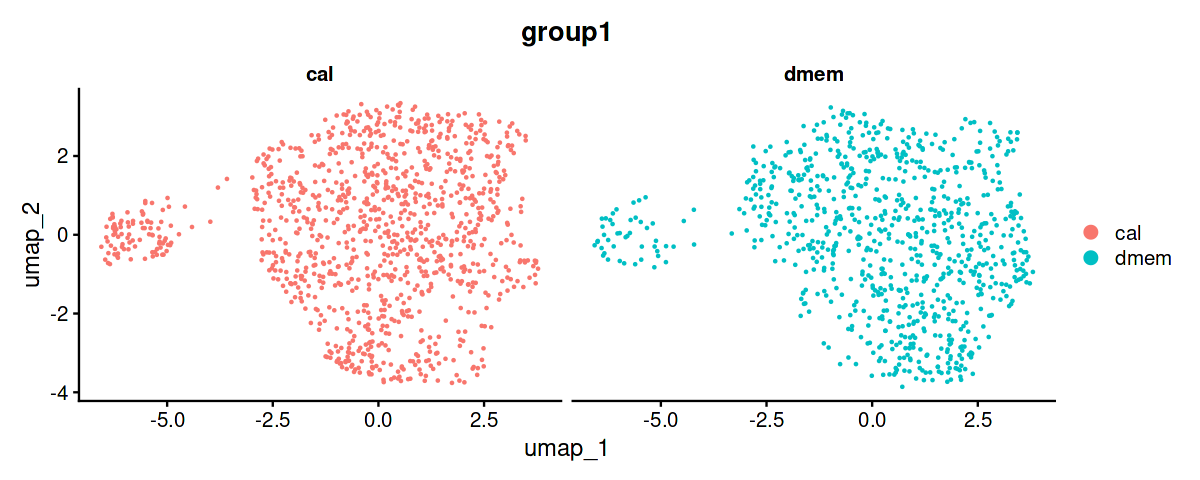

In [60]:
options(repr.plot.height = 4, repr.plot.width = 10)
DimPlot(merged_counts_perturb1_cal_dmem, reduction = "umap", group.by = "group1", pt.size = .1, split.by = 'group1')

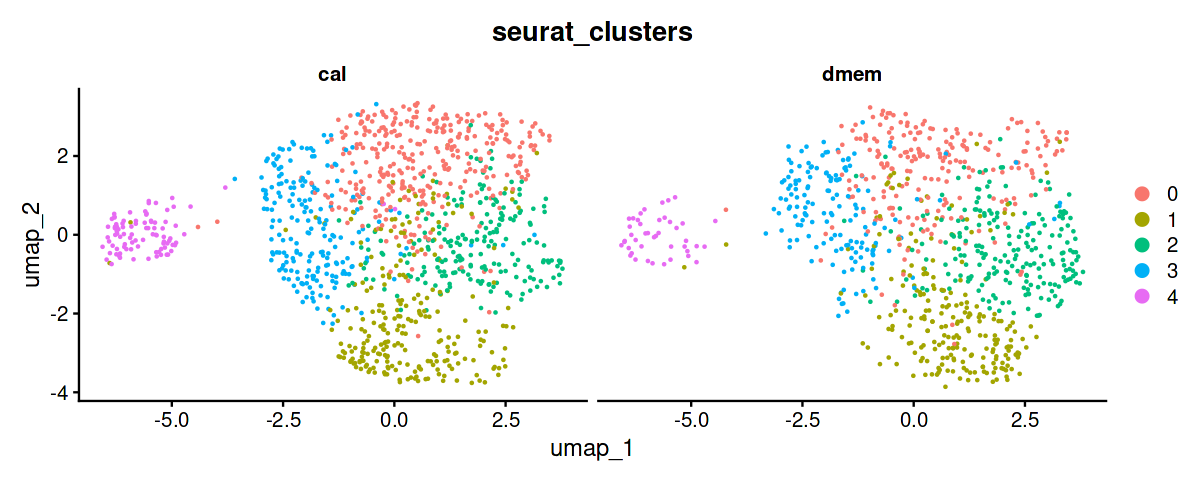

In [61]:
options(repr.plot.height = 4, repr.plot.width = 10)
DimPlot(merged_counts_perturb1_cal_dmem, reduction = "umap", group.by = "seurat_clusters", pt.size = .1, split.by = 'group1')

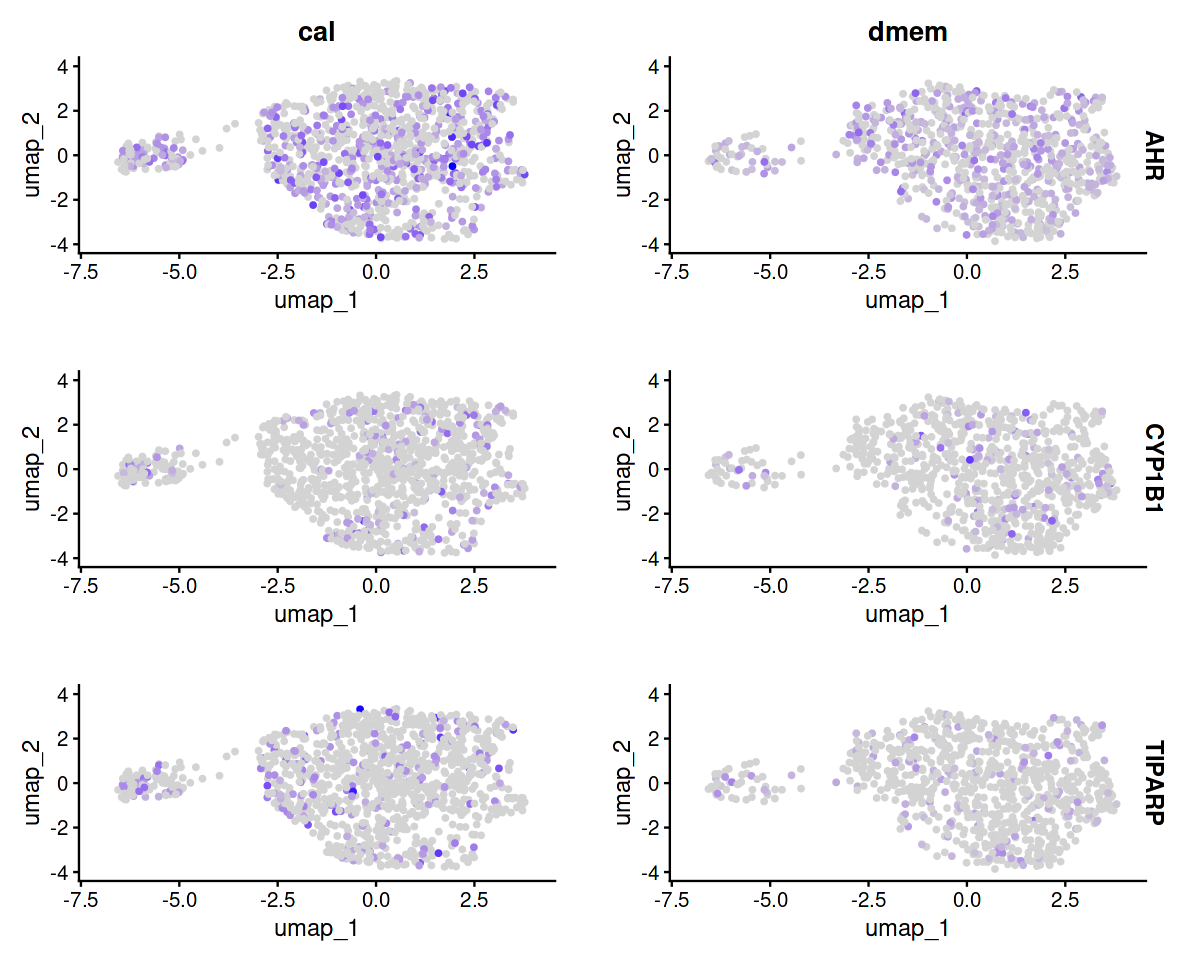

In [67]:
options(repr.plot.height = 8, repr.plot.width = 10)
FeaturePlot(merged_counts_perturb1_cal_dmem, features = c("AHR",
"CYP1B1",
"TIPARP"
), split.by = 'group1', ncol = 3)

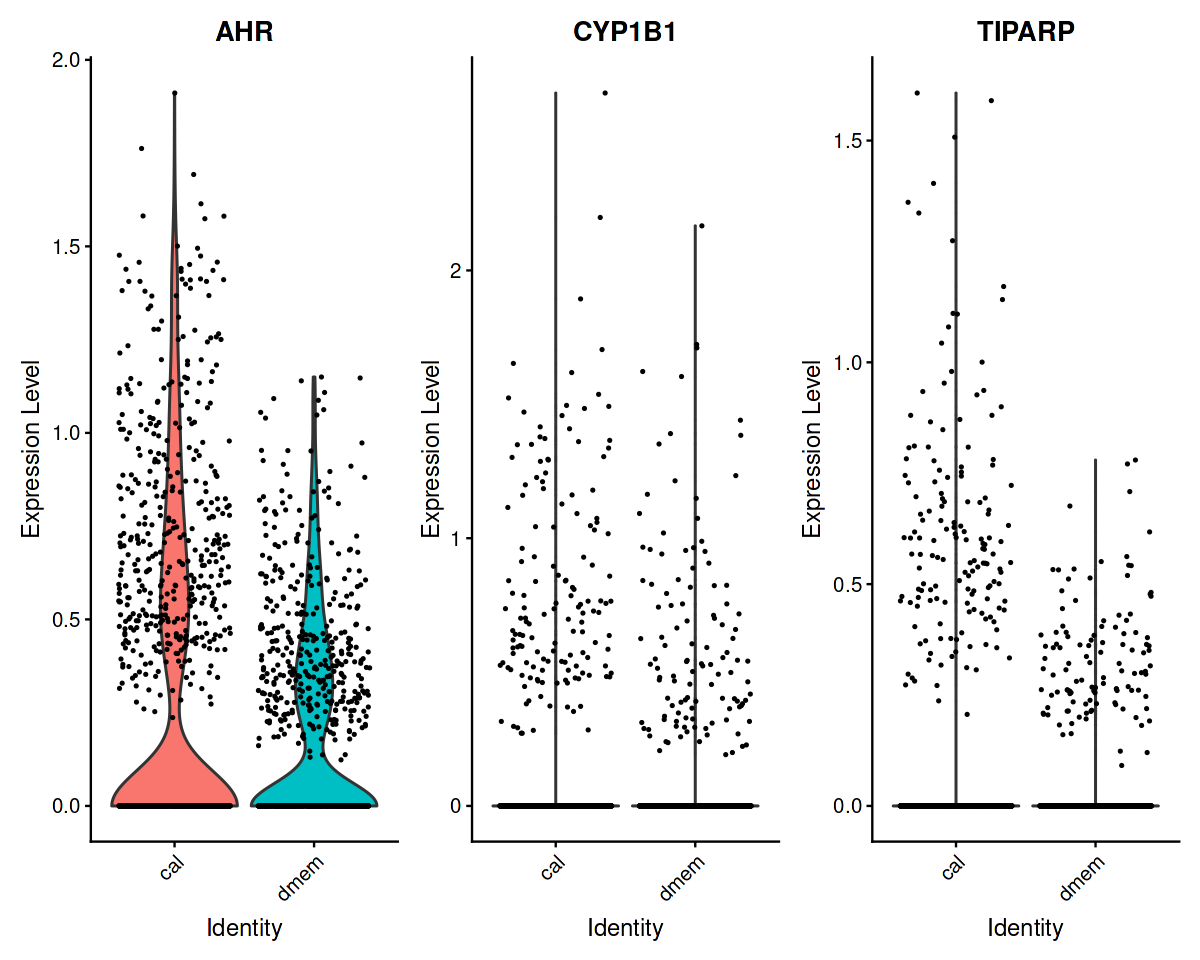

In [74]:
VlnPlot(
  merged_counts_perturb1_cal_dmem,
  features = c("AHR", "CYP1B1", "TIPARP"),
  group.by = "group1",
  pt.size = 0.2,
  combine = TRUE
)

Warning message:
“The following features are not present in the object: RP11-54O7.3, RP4-625H18.2, RP1-167F1.2, RP11-49I11.2, not searching for symbol synonyms”


orig.ident nCount_RNA nFeature_RNA nCount_feature
AAACGAAGTTCCGGTG-2 2          35103      6319          683          
AAACGAATCCTCACTG-2 2          21186      5473         3207          
AAAGAACAGCCTCATA-2 2          31136      6671          449          
AAAGAACCACCCTTAC-2 2          36281      6984          614          
AAAGAACCATCGCCTT-2 2          36498      6146           59          
AAAGAACGTTGGAGAC-2 2          20884      5204          638          
AAAGGTACATCATTGG-2 2          22686      5457          330          
AAAGGTAGTGCACATT-2 2          24360      5551          695          
AAAGTGAAGCCATTGT-2 2          22762      5805          985          
AAAGTGAAGGGACCAT-2 2          22317      5110         1502          
                   nFeature_feature group group1 percent.mt RNA_snn_res.0.5
AAACGAAGTTCCGGTG-2 19               2     dmem   4.8115546  1              
AAACGAATCCTCACTG-2 11               2     dmem   3.2757481  3              
AAAGAACAGCCTCATA-2  5               2     dmem   4.3004882  2              
AAAGAACCACCCTTAC-2  5               2     dmem   3.1641906  2              
AAAGAACCATCGCCTT-2  6               2     dmem   0.1945312  1              
AAAGAACGTTGGAGAC-2  8               2     dmem   3.3901551  3              
AAAGGTACATCATTGG-2  3               2     dmem   2.3803227  2              
AAAGGTAGTGCACATT-2 12               2     dmem   1.1042693  1              
AAAGTGAAGCCATTGT-2  6               2     dmem   1.0104560  0              
AAAGTGAAGGGACCAT-2 16               2     dmem   4.3867903  2              
                   seurat_clusters cell_barcode num_features
AAACGAAGTTCCGGTG-2 1               4            2           
AAACGAATCCTCACTG-2 3               5            2           
AAAGAACAGCCTCATA-2 2               7            2           
AAAGAACCACCCTTAC-2 2               8            1           
AAAGAACCATCGCCTT-2 1               9            1           
AAAGAACGTTGGAGAC-2 3               10           2           
AAAGGTACATCATTGG-2 2               11           2           
AAAGGTAGTGCACATT-2 1               12           2           
AAAGTGAAGCCATTGT-2 0               14           2           
AAAGTGAAGGGACCAT-2 2               15           2           
                   feature_call        num_umis guide   calcification_score1
AAACGAAGTTCCGGTG-2 SMAD3-2|SMAD3-5     553|131  SMAD3   -0.03716357         
AAACGAATCCTCACTG-2 KLF4-2|KLF4-5       2304|981 KLF4    -0.02280805         
AAAGAACAGCCTCATA-2 NFE2L2-1|NFE2L2-4   421|45   NFE2L2  -0.01664601         
AAAGAACCACCCTTAC-2 TWIST1-1            630      TWIST1  -0.01511426         
AAAGAACCATCGCCTT-2 SMAD3-2             48       SMAD3   -0.01657962         
AAAGAACGTTGGAGAC-2 TWIST1-1|TWIST1-4   246|419  TWIST1  -0.06964329         
AAAGGTACATCATTGG-2 SMAD3-1|SMAD3-5     323|18   SMAD3    0.02598736         
AAAGGTAGTGCACATT-2 NFE2L2-1|NFE2L2-4   603|89   NFE2L2  -0.02149692         
AAAGTGAAGCCATTGT-2 NFE2L2-1|NFE2L2-4   879|162  NFE2L2  -0.03397278         
AAAGTGAAGGGACCAT-2 SMARCA4-1|SMARCA4-4 934|588  SMARCA4 -0.05017238

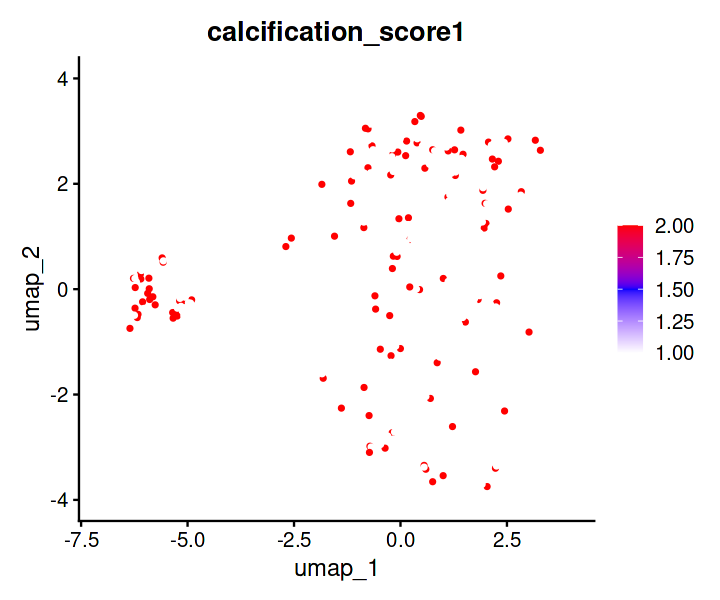

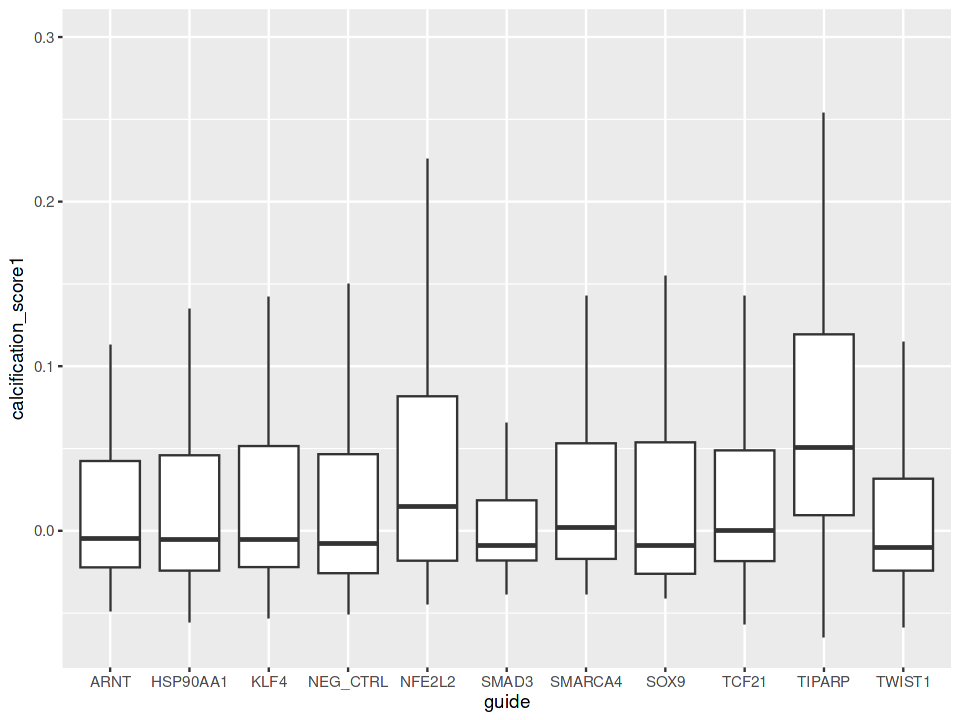

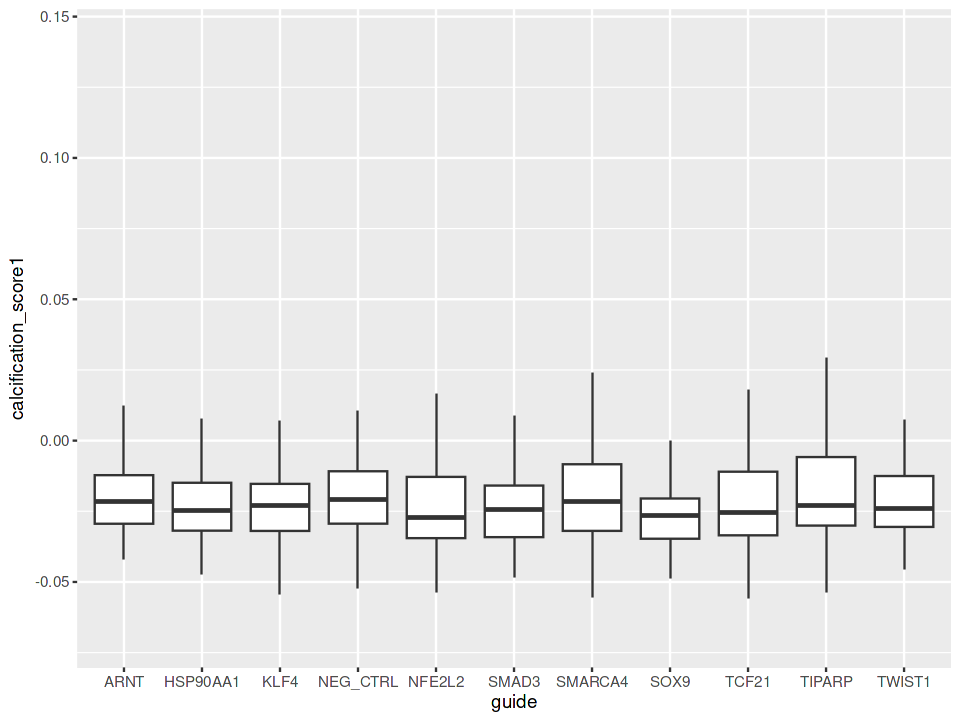

In [54]:
##Calculate calcification scores for feature expression programs in single cells
cd_features <- list(c('RP11-54O7.3', 'SAMD11', 'RASL11B', 'RP4-625H18.2', 'ANO1', 'COMP', 'RP1-167F1.2', 'SERPIND1', 'ID3', 'ECSCR', 'MMP1', 'AC133785.1', 'ID1', 'NOTUM', 'FXYD6', 'RP11-49I11.2', 'RELN', 'PDE3B', 'ID4', 'TINAGL1'))
merged_counts_perturb1_cal_dmem <- AddModuleScore(
  object = merged_counts_perturb1_cal_dmem,
  features = cd_features,
  ctrl = 5,
  name = 'calcification_score',
    seed = 1
)

head(x = merged_counts_perturb1_cal_dmem[])
my_palette <- c("white", "blue", "red")
names(my_palette) <- c("0", "1", "2")
options(repr.plot.height = 5, repr.plot.width = 6)

Idents(merged_counts_perturb1_cal_dmem) <- 'calcification_score1'
FeaturePlot(merged_counts_perturb1_cal_dmem, features = "calcification_score1", cols = my_palette)
Idents(merged_counts_perturb1_cal_dmem)<-merged_counts_perturb1_cal_dmem$group1
subset(merged_counts_perturb1_cal_dmem,idents = c('cal'))->calcification
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(calcification@meta.data, aes(x = guide, y = calcification_score1)) +
  geom_boxplot(outlier.shape = NA)

Idents(merged_counts_perturb1_cal_dmem)<-merged_counts_perturb1_cal_dmem$group1
subset(merged_counts_perturb1_cal_dmem,idents = c('dmem'))->dmem
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(dmem@meta.data, aes(x = guide, y = calcification_score1)) +
  geom_boxplot(outlier.shape = NA)

In [55]:
###calcification p value
library(dplyr)
meta <- calcification@meta.data

score_col <- "calcification_score1"
guide_col <- "guide"
control_label <- "NEG_CTRL" 
meta_ctrl <- meta %>% filter(!!sym(guide_col) == control_label)
guides <- setdiff(unique(meta[[guide_col]]), control_label)
res <- data.frame(guide = guides, p_value = NA, median_diff = NA)
for (g in guides) {
  meta_g <- meta %>% filter(!!sym(guide_col) == g)
  test <- wilcox.test(meta_g[[score_col]], meta_ctrl[[score_col]], exact = FALSE)
  res[res$guide == g, "p_value"] <- test$p.value
  res[res$guide == g, "median_diff"] <- median(meta_g[[score_col]], na.rm = TRUE) - median(meta_ctrl[[score_col]], na.rm = TRUE)
}
res$FDR <- p.adjust(res$p_value, method = "BH")
res <- res %>% arrange(p_value)
print(res)

      guide      p_value  median_diff          FDR
1    TIPARP 4.861547e-06  0.058220899 4.861547e-05
2    NFE2L2 4.148943e-02  0.022416451 2.074471e-01
3   SMARCA4 1.083946e-01  0.009763870 3.613155e-01
4     TCF21 2.479657e-01  0.007779329 6.199143e-01
5      KLF4 5.079145e-01  0.002424546 9.010144e-01
6      ARNT 6.748915e-01  0.003048523 9.010144e-01
7      SOX9 7.885404e-01 -0.001200128 9.010144e-01
8  HSP90AA1 8.002353e-01  0.002424731 9.010144e-01
9    TWIST1 8.109130e-01 -0.002289410 9.010144e-01
10    SMAD3 9.399142e-01 -0.001435443 9.399142e-01


In [56]:
###dmem p value
library(dplyr)
meta <- dmem@meta.data

score_col <- "calcification_score1"
guide_col <- "guide"
control_label <- "NEG_CTRL" 
meta_ctrl <- meta %>% filter(!!sym(guide_col) == control_label)
guides <- setdiff(unique(meta[[guide_col]]), control_label)
res <- data.frame(guide = guides, p_value = NA, median_diff = NA)
for (g in guides) {
  meta_g <- meta %>% filter(!!sym(guide_col) == g)
  test <- wilcox.test(meta_g[[score_col]], meta_ctrl[[score_col]], exact = FALSE)
  res[res$guide == g, "p_value"] <- test$p.value
  res[res$guide == g, "median_diff"] <- median(meta_g[[score_col]], na.rm = TRUE) - median(meta_ctrl[[score_col]], na.rm = TRUE)
}
res$FDR <- p.adjust(res$p_value, method = "BH")
res <- res %>% arrange(p_value)
print(res)

      guide    p_value   median_diff       FDR
1      SOX9 0.01211508 -0.0058521958 0.1211508
2    NFE2L2 0.03982297 -0.0066095726 0.1991149
3      KLF4 0.12937236 -0.0022612884 0.2971534
4     SMAD3 0.14384159 -0.0035398059 0.2971534
5  HSP90AA1 0.14857672 -0.0039325452 0.2971534
6     TCF21 0.18093309 -0.0046774682 0.3015551
7    TWIST1 0.22340145 -0.0033967272 0.3191449
8   SMARCA4 0.42032132 -0.0009230465 0.5254017
9      ARNT 0.58410613 -0.0006962864 0.6490068
10   TIPARP 0.86996490 -0.0021374068 0.8699649


In [ ]:
############################  mixscale  ##################################

In [ ]:
library(Seurat)
library(ggridges)
library(ggplot2)
library(Mixscale)
library(EnhancedVolcano)

In [ ]:
merged_counts_perturb1[[]]

In [ ]:
# Read in the expression matrix The first row is a header row, the first column is rownames
exp.mat <- read.table(file = "/VOSNE/tracy/nestorawa_forcellcycle_expressionMatrix.txt", header = TRUE,
    as.is = TRUE, row.names = 1)
# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
# Assign cell cycle store
merged_counts_perturb_cell_cycle <- CellCycleScoring(merged_counts_perturb1, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
# Running a PCA on cell cycle genes reveals, unsurprisingly, that cells separate entirely by phase
merged_counts_perturb_cell_cycle <- RunPCA(merged_counts_perturb_cell_cycle, features = c(s.genes, g2m.genes))
DimPlot(merged_counts_perturb_cell_cycle)

In [ ]:
options(repr.plot.height = 6, repr.plot.width = 16)
p1=DimPlot(merged_counts_perturb1, group.by = "group1", raster=FALSE)
p2=DimPlot(merged_counts_perturb1, raster=FALSE)
p3=DimPlot(merged_counts_perturb_cell_cycle)
p1+p2+p3

In [ ]:
table(merged_counts_perturb_cell_cycle$group1)

In [ ]:
table(merged_counts_perturb_cell_cycle$guide)

In [ ]:
subset(merged_counts_perturb_cell_cycle,subset=group1=="pbs")->merged_counts_perturb_cell_cycle

In [ ]:
table(merged_counts_perturb_cell_cycle$group1)

In [ ]:
merged_counts_perturb_cell_cycle[[]]

In [ ]:
names(merged_counts_perturb_cell_cycle@meta.data)[15] <- 'gene'

In [ ]:
merged_counts_perturb_cell_cycle@meta.data

In [ ]:
seurat_obj <- CalcPerturbSig(
    object = merged_counts_perturb_cell_cycle, 
    assay = "RNA", 
    slot = "data", 
    gd.class ="gene", 
    nt.cell.class = "NEG_CTRL", 
    reduction = "pca", 
    ndims = 40, 
    num.neighbors = 20, 
    new.assay.name = "PRTB", 
    split.by = NULL) 

In [ ]:
# Mixscale
seurat_obj = RunMixscale(
    object = seurat_obj, 
    assay = "PRTB", 
    slot = "scale.data", 
    labels = "gene", 
    nt.class.name = "NEG_CTRL", 
    min.de.genes = 5, 
    logfc.threshold = 0.2,
    de.assay = "RNA",
    max.de.genes = 100, 
    new.class.name = "mixscale_score", 
    fine.mode = F, 
    verbose = F, 
    split.by = NULL)

In [ ]:
# a. Check the distribution of the scores for the perturbations
RidgePlot(
    seurat_obj,
    features = "mixscale_score",
    group.by = "gene") + NoLegend()

In [ ]:
# b. Check if the scores correlate with the expression level of the target gene itself
Mixscale_ScatterPlot(object = seurat_obj, 
                     nt.class.name = "NEG_CTRL", 
                     slct.ident = unique(seurat_obj$gene)[unique(seurat_obj$gene) != "NEG_CTRL"][1:10], 
                     nbin = 10, 
                     facet_wrap = "gene") + NoLegend()

In [ ]:
table(seurat_obj$gene)

In [ ]:
# run score-based weighted DE test for selected perturbations. It will return a list of data frames (one for each perturbation)
de_res = Run_wmvRegDE(object = seurat_obj, assay = "RNA", slot = "counts",
                      labels = "gene", nt.class.name = "NEG_CTRL", 
                      PRTB_list = c("ARNT", "NFE2L2", "SMAD3","HSP90AA1","KLF4","SMARCA4","SOX9","TCF21","TIPARP","TWIST1"),
                      logfc.threshold = 0.2, 
                      split.by = NULL)

# have a quick look at the DE results
head(de_res[[1]])

In [ ]:
de_res

In [ ]:
str(de_res)

In [ ]:
# Create a directory to save CSV files if it doesn't exist
if (!file.exists("output_csv")) {
  dir.create("output_csv")
}
# Iterate over each data frame in the list
for (i in seq_along(de_res)) {
  # Generate a unique file name for each data frame
  file_name <- paste0("output_csv/data_frame_", i, ".csv")
  
  # Save the data frame to CSV
  write.csv(de_res[[i]], file = file_name, row.names = FALSE)
}

In [ ]:
# select the top 20 DE genes from the perturbation
top_res = de_res[["ARNT"]][order(de_res[["ARNT"]]$p_weight)[1:20], ]
# order the DE genes based on its log-fold-change
top_DEG = rownames(top_res[order(top_res$log2FC, decreasing = T), ])

# heatmap for the top DE genes. cells ordered by Mixscale scores. The expression level of the target gene will be plotted in the first row.
Mixscale_DoHeatmap(object = seurat_obj, 
                   labels = "gene", 
                   nt.class.name = "NEG_CTRL", 
                   slct.ident = "ARNT", 
                   mixscale.score.name = "mixscale_score",
                   features = c("ARNT", top_DEG), angle = 0, hjust = 0.5) 

In [ ]:
# select the top 20 DE genes from the perturbation
top_res = de_res[["HSP90AA1"]][order(de_res[["HSP90AA1"]]$p_weight)[1:20], ]
# order the DE genes based on its log-fold-change
top_DEG = rownames(top_res[order(top_res$log2FC, decreasing = T), ])

# heatmap for the top DE genes. cells ordered by Mixscale scores. The expression level of the target gene will be plotted in the first row.
Mixscale_DoHeatmap(object = seurat_obj, 
                   labels = "gene", 
                   nt.class.name = "NEG_CTRL", 
                   slct.ident = "HSP90AA1", 
                   mixscale.score.name = "mixscale_score",
                   features = c("HSP90AA1", top_DEG), angle = 0, hjust = 0.5) 

In [ ]:
# select the top 20 DE genes from the perturbation
top_res = de_res[["KLF4"]][order(de_res[["KLF4"]]$p_weight)[1:20], ]
# order the DE genes based on its log-fold-change
top_DEG = rownames(top_res[order(top_res$log2FC, decreasing = T), ])

# heatmap for the top DE genes. cells ordered by Mixscale scores. The expression level of the target gene will be plotted in the first row.
Mixscale_DoHeatmap(object = seurat_obj, 
                   labels = "gene", 
                   nt.class.name = "NEG_CTRL", 
                   slct.ident = "KLF4", 
                   mixscale.score.name = "mixscale_score",
                   features = c("KLF4", top_DEG), angle = 0, hjust = 0.5) 

In [ ]:
# select the top 20 DE genes from the perturbation
top_res = de_res[["NFE2L2"]][order(de_res[["NFE2L2"]]$p_weight)[1:20], ]
# order the DE genes based on its log-fold-change
top_DEG = rownames(top_res[order(top_res$log2FC, decreasing = T), ])

# heatmap for the top DE genes. cells ordered by Mixscale scores. The expression level of the target gene will be plotted in the first row.
Mixscale_DoHeatmap(object = seurat_obj, 
                   labels = "gene", 
                   nt.class.name = "NEG_CTRL", 
                   slct.ident = "NFE2L2", 
                   mixscale.score.name = "mixscale_score",
                   features = c("NFE2L2", top_DEG), angle = 0, hjust = 0.5) 

In [ ]:
# select the top 20 DE genes from the perturbation
top_res = de_res[["SMAD3"]][order(de_res[["SMAD3"]]$p_weight)[1:20], ]
# order the DE genes based on its log-fold-change
top_DEG = rownames(top_res[order(top_res$log2FC, decreasing = T), ])

# heatmap for the top DE genes. cells ordered by Mixscale scores. The expression level of the target gene will be plotted in the first row.
Mixscale_DoHeatmap(object = seurat_obj, 
                   labels = "gene", 
                   nt.class.name = "NEG_CTRL", 
                   slct.ident = "SMAD3", 
                   mixscale.score.name = "mixscale_score",
                   features = c("SMAD3", top_DEG), angle = 0, hjust = 0.5) 

In [ ]:
# select the top 20 DE genes from the perturbation
top_res = de_res[["SMARCA4"]][order(de_res[["SMARCA4"]]$p_weight)[1:20], ]
# order the DE genes based on its log-fold-change
top_DEG = rownames(top_res[order(top_res$log2FC, decreasing = T), ])

# heatmap for the top DE genes. cells ordered by Mixscale scores. The expression level of the target gene will be plotted in the first row.
Mixscale_DoHeatmap(object = seurat_obj, 
                   labels = "gene", 
                   nt.class.name = "NEG_CTRL", 
                   slct.ident = "SMARCA4", 
                   mixscale.score.name = "mixscale_score",
                   features = c("SMARCA4", top_DEG), angle = 0, hjust = 0.5) 

In [ ]:
# select the top 20 DE genes from the perturbation
top_res = de_res[["SOX9"]][order(de_res[["SOX9"]]$p_weight)[1:20], ]
# order the DE genes based on its log-fold-change
top_DEG = rownames(top_res[order(top_res$log2FC, decreasing = T), ])

# heatmap for the top DE genes. cells ordered by Mixscale scores. The expression level of the target gene will be plotted in the first row.
Mixscale_DoHeatmap(object = seurat_obj, 
                   labels = "gene", 
                   nt.class.name = "NEG_CTRL", 
                   slct.ident = "SOX9", 
                   mixscale.score.name = "mixscale_score",
                   features = c("SOX9", top_DEG), angle = 0, hjust = 0.5) 

In [ ]:
# select the top 20 DE genes from the perturbation
top_res = de_res[["TCF21"]][order(de_res[["TCF21"]]$p_weight)[1:20], ]
# order the DE genes based on its log-fold-change
top_DEG = rownames(top_res[order(top_res$log2FC, decreasing = T), ])

# heatmap for the top DE genes. cells ordered by Mixscale scores. The expression level of the target gene will be plotted in the first row.
Mixscale_DoHeatmap(object = seurat_obj, 
                   labels = "gene", 
                   nt.class.name = "NEG_CTRL", 
                   slct.ident = "TCF21", 
                   mixscale.score.name = "mixscale_score",
                   features = c("TCF21", top_DEG), angle = 0, hjust = 0.5) 

In [ ]:
# select the top 20 DE genes from the perturbation
top_res = de_res[["TIPARP"]][order(de_res[["TIPARP"]]$p_weight)[1:20], ]
# order the DE genes based on its log-fold-change
top_DEG = rownames(top_res[order(top_res$log2FC, decreasing = T), ])

# heatmap for the top DE genes. cells ordered by Mixscale scores. The expression level of the target gene will be plotted in the first row.
Mixscale_DoHeatmap(object = seurat_obj, 
                   labels = "gene", 
                   nt.class.name = "NEG_CTRL", 
                   slct.ident = "TIPARP", 
                   mixscale.score.name = "mixscale_score",
                   features = c("TIPARP", top_DEG), angle = 0, hjust = 0.5) 

In [ ]:
# select the top 20 DE genes from the perturbation
top_res = de_res[["TWIST1"]][order(de_res[["TWIST1"]]$p_weight)[1:20], ]
# order the DE genes based on its log-fold-change
top_DEG = rownames(top_res[order(top_res$log2FC, decreasing = T), ])

# heatmap for the top DE genes. cells ordered by Mixscale scores. The expression level of the target gene will be plotted in the first row.
Mixscale_DoHeatmap(object = seurat_obj, 
                   labels = "gene", 
                   nt.class.name = "NEG_CTRL", 
                   slct.ident = "TWIST1", 
                   mixscale.score.name = "mixscale_score",
                   features = c("TWIST1", top_DEG), angle = 0, hjust = 0.5) 

In [ ]:
###volcano plots
library(EnhancedVolcano)

In [ ]:
# ARNT
read.csv(file = "/home/gzq0002/arnt.csv", header = TRUE) ->arnt
options(repr.plot.height = 10, repr.plot.width = 10)
EnhancedVolcano(arnt , 
                arnt$gene_ID,
                x ="log2FC", 
                y ="p_weight",
               lab = as.character(arnt$gene_ID, pointSize = 4.0))

In [ ]:
# HSP90AA1
read.csv(file = "/home/gzq0002/hsp90aa1.csv", header = TRUE) ->hsp90aa1
options(repr.plot.height = 10, repr.plot.width = 10)
EnhancedVolcano(hsp90aa1 , 
                hsp90aa1$gene_ID,
                x ="log2FC", 
                y ="p_weight",
                ylim = c(0, 15),
               lab = as.character(hsp90aa1$gene_ID, pointSize = 4.0))

In [ ]:
# HSP90AA1
read.csv(file = "/home/gzq0002/hsp90aa1.csv", header = TRUE) ->hsp90aa1
options(repr.plot.height = 10, repr.plot.width = 10)
EnhancedVolcano(hsp90aa1 , 
                hsp90aa1$gene_ID,
                x ="log2FC", 
                y ="p_weight",
               lab = as.character(hsp90aa1$gene_ID, pointSize = 4.0))

In [ ]:
# tcf21
read.csv(file = "/home/gzq0002/tcf21.csv", header = TRUE) ->tcf21
options(repr.plot.height = 10, repr.plot.width = 10)
EnhancedVolcano(tcf21 , 
                tcf21$gene_ID,
                x ="log2FC", 
                y ="p_weight",
               lab = as.character(tcf21$gene_ID, pointSize = 4.0))

In [ ]:
# smarca4
read.csv(file = "/home/gzq0002/smarca4.csv", header = TRUE) ->smarca4
options(repr.plot.height = 10, repr.plot.width = 10)
EnhancedVolcano(smarca4 , 
                smarca4$gene_ID,
                x ="log2FC", 
                y ="p_weight",
               lab = as.character(smarca4$gene_ID, pointSize = 4.0))